## ShuffleNet

In [43]:
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
!pip install timm #tqdm wandb matplotlib 

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
#@title import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import time
import numpy as np
from tqdm.notebook import tqdm
import wandb
import matplotlib.pyplot as plt
from collections import OrderedDict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
#@title model architecture
class ChannelShuffle(nn.Module):
    """Channel shuffle operation"""
    def __init__(self, groups):
        super(ChannelShuffle, self).__init__()
        self.groups = groups

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        channels_per_group = channels // self.groups
        
        # Reshape and transpose for shuffle
        x = x.view(batch_size, self.groups, channels_per_group, height, width)
        x = x.transpose(1, 2).contiguous()
        x = x.view(batch_size, channels, height, width)
        return x

class ShuffleBlock(nn.Module):
    """ShuffleNet basic block"""
    def __init__(self, in_channels, out_channels, groups, stride=1):
        super(ShuffleBlock, self).__init__()
        self.stride = stride
        self.groups = groups
        
        # First 1x1 grouped convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, 
                              groups=groups, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels//4)
        
        # Channel shuffle
        self.shuffle = ChannelShuffle(groups)
        
        # 3x3 depthwise convolution
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3,
                              stride=stride, padding=1, groups=out_channels//4, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        
        # Second 1x1 grouped convolution
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1,
                              groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
            )
            
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        shortcut = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.shuffle(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.stride == 2:
            out = torch.cat([shortcut, out], dim=1)
        else:
            out = out + shortcut
            
        out = self.relu(out)
        return out

class ShuffleNet(nn.Module):
    """ShuffleNet for CIFAR-10"""
    def __init__(self, groups=3, num_classes=10):
        super(ShuffleNet, self).__init__()
        self.groups = groups
        
        # Stage configurations based on groups
        if groups == 1:
            out_channels = [24, 144, 288, 576]
        elif groups == 2:
            out_channels = [24, 200, 400, 800]
        elif groups == 3:
            out_channels = [24, 240, 480, 960]
        elif groups == 4:
            out_channels = [24, 272, 544, 1088]
        elif groups == 8:
            out_channels = [24, 384, 768, 1536]
        else:
            raise ValueError("Groups not supported")
        
        # First convolution (modified for CIFAR-10's 32x32 input)
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.relu = nn.ReLU(inplace=True)
        
        # Stage 2
        self.stage2 = self._make_stage(24, out_channels[1], 4, stride=2)
        
        # Stage 3  
        self.stage3 = self._make_stage(out_channels[1], out_channels[2], 8, stride=2)
        
        # Stage 4
        self.stage4 = self._make_stage(out_channels[2], out_channels[3], 4, stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out_channels[3], num_classes)
        
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        # First block with stride
        layers.append(ShuffleBlock(in_channels, out_channels - in_channels, 
                                 self.groups, stride=stride))
        
        # Remaining blocks
        for i in range(num_blocks - 1):
            layers.append(ShuffleBlock(out_channels, out_channels, self.groups))
            
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print("✅ ShuffleNet architecture defined successfully!")

✅ ShuffleNet architecture defined successfully!


In [5]:
#@title test shape
def test_model_shapes():
    """Test model with dummy data to verify input/output shapes"""
    print("Testing ShuffleNet with dummy data...")
    
    # Create model
    model = ShuffleNet(groups=3, num_classes=10)
    model.eval()
    
    # Test different batch sizes
    test_cases = [
        (1, 3, 32, 32),   # Single image
        (8, 3, 32, 32),   # Small batch
        (32, 3, 32, 32),  # Medium batch
    ]
    
    for batch_size, channels, height, width in test_cases:
        print(f"\n📊 Testing input shape: ({batch_size}, {channels}, {height}, {width})")
        
        # Create dummy input
        dummy_input = torch.randn(batch_size, channels, height, width)
        
        # Forward pass
        with torch.no_grad():
            output = model(dummy_input)
        
        print(f"   Input shape:  {dummy_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   Expected:     ({batch_size}, 10)")
        
        # Verify output shape
        assert output.shape == (batch_size, 10), f"Wrong output shape: {output.shape}"
        print("   ✅ Shape test passed!")
    
    # Test model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n📈 Model Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")
    
    return model

# Run the test
test_model = test_model_shapes()

Testing ShuffleNet with dummy data...

📊 Testing input shape: (1, 3, 32, 32)
   Input shape:  torch.Size([1, 3, 32, 32])
   Output shape: torch.Size([1, 10])
   Expected:     (1, 10)
   ✅ Shape test passed!

📊 Testing input shape: (8, 3, 32, 32)
   Input shape:  torch.Size([8, 3, 32, 32])
   Output shape: torch.Size([8, 10])
   Expected:     (8, 10)
   ✅ Shape test passed!

📊 Testing input shape: (32, 3, 32, 32)
   Input shape:  torch.Size([32, 3, 32, 32])
   Output shape: torch.Size([32, 10])
   Expected:     (32, 10)
   ✅ Shape test passed!

📈 Model Statistics:
   Total parameters: 862,480
   Trainable parameters: 862,480
   Model size: 3.29 MB (float32)


In [6]:
#@title Utility Functions for Evaluation
def count_flops(model, input_size=(1, 3, 32, 32)):
    """Count FLOPs for the model"""
    def flop_count(module, input, output):
        if isinstance(module, nn.Conv2d):
            # For convolution: FLOPs = output_elements * (kernel_size^2 * input_channels / groups)
            output_elements = output.nelement()
            kernel_flops = module.kernel_size[0] * module.kernel_size[1] * module.in_channels // module.groups
            flops = output_elements * kernel_flops
            module.__flops__ += flops
        elif isinstance(module, nn.Linear):
            # For linear layer: FLOPs = input_features * output_features
            flops = module.in_features * module.out_features
            module.__flops__ += flops

    model.eval()
    
    # Register hooks
    handles = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            module.__flops__ = 0
            handle = module.register_forward_hook(flop_count)
            handles.append(handle)
    
    # Forward pass
    input_tensor = torch.randn(input_size).to(next(model.parameters()).device)
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Calculate total FLOPs
    total_flops = 0
    for module in model.modules():
        if hasattr(module, '__flops__'):
            total_flops += module.__flops__
    
    # Remove hooks
    for handle in handles:
        handle.remove()
    
    return total_flops

def measure_inference_time(model, input_size=(1, 3, 32, 32), num_runs=100):
    """Measure inference latency"""
    model.eval()
    device = next(model.parameters()).device
    
    # Warmup
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)
    
    # Measure time
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_time = time.time()
    
    for _ in range(num_runs):
        with torch.no_grad():
            _ = model(dummy_input)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    return avg_time * 1000  # Return in milliseconds

def calculate_accuracy(model, dataloader, device, top_k=(1, 5)):
    """Calculate Top-1 and Top-5 accuracy"""
    model.eval()
    correct = {k: 0 for k in top_k}
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Calculating accuracy", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # Get top-k predictions
            _, pred = outputs.topk(max(top_k), dim=1, largest=True, sorted=True)
            
            total += targets.size(0)
            
            for k in top_k:
                correct_k = pred[:, :k].eq(targets.view(-1, 1).expand_as(pred[:, :k]))
                correct[k] += correct_k.sum().item()
    
    accuracies = {k: 100. * correct[k] / total for k in top_k}
    return accuracies

print("✅ Utility functions defined successfully!")

✅ Utility functions defined successfully!


In [7]:
#@title dataloader
def get_cifar10_dataloaders(batch_size=128, num_workers=2):
    """Load CIFAR-10 dataset with proper preprocessing"""
    
    # Data preprocessing
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                           num_workers=num_workers, pin_memory=True)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, pin_memory=True)
    
    return trainloader, testloader, trainset, testset

def get_small_sample_dataloaders(trainset, testset, train_samples=100, test_samples=50, batch_size=32):
    """Create small sample dataloaders for overfitting test"""
    # Create small subsets
    train_indices = torch.randperm(len(trainset))[:train_samples]
    test_indices = torch.randperm(len(testset))[:test_samples]
    
    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)
    
    train_loader_small = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader_small = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader_small, test_loader_small

# Load data
print("Loading CIFAR-10 dataset...")
trainloader, testloader, trainset, testset = get_cifar10_dataloaders()

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"✅ Dataset loaded successfully!")
print(f"   Training samples: {len(trainset)}")
print(f"   Test samples: {len(testset)}")
print(f"   Classes: {classes}")


Loading CIFAR-10 dataset...


100.0%


✅ Dataset loaded successfully!
   Training samples: 50000
   Test samples: 10000
   Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Creating small sample dataset...
🔍 Testing model's ability to overfit small sample...


Epoch 1/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss = 2.2113, Accuracy = 21.00%


Epoch 6/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss = 2.1015, Accuracy = 23.00%


Epoch 11/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss = 1.9872, Accuracy = 33.00%


Epoch 16/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: Loss = 1.9251, Accuracy = 40.00%


Epoch 21/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25: Loss = 1.8111, Accuracy = 39.00%


Epoch 26/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30: Loss = 1.6552, Accuracy = 44.00%


Epoch 31/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35: Loss = 1.7088, Accuracy = 42.00%


Epoch 36/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40: Loss = 1.5524, Accuracy = 53.00%


Epoch 41/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45: Loss = 1.6815, Accuracy = 52.00%


Epoch 46/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50: Loss = 1.2289, Accuracy = 60.00%


Epoch 51/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55: Loss = 1.3235, Accuracy = 61.00%


Epoch 56/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60: Loss = 1.2808, Accuracy = 60.00%


Epoch 61/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65: Loss = 1.2469, Accuracy = 66.00%


Epoch 66/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70: Loss = 1.0994, Accuracy = 69.00%


Epoch 71/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75: Loss = 1.1144, Accuracy = 65.00%


Epoch 76/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80: Loss = 1.0515, Accuracy = 72.00%


Epoch 81/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85: Loss = 1.3321, Accuracy = 76.00%


Epoch 86/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90: Loss = 0.9858, Accuracy = 77.00%


Epoch 91/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95: Loss = 0.9085, Accuracy = 75.00%


Epoch 96/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100: Loss = 0.7573, Accuracy = 72.00%


Epoch 101/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105: Loss = 1.0412, Accuracy = 78.00%


Epoch 106/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110: Loss = 0.8211, Accuracy = 86.00%


Epoch 111/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115: Loss = 0.6868, Accuracy = 81.00%


Epoch 116/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120: Loss = 0.6011, Accuracy = 84.00%


Epoch 121/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125: Loss = 0.5011, Accuracy = 90.00%


Epoch 126/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130: Loss = 0.5024, Accuracy = 87.00%


Epoch 131/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135: Loss = 0.7271, Accuracy = 86.00%


Epoch 136/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140: Loss = 0.5048, Accuracy = 90.00%


Epoch 141/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145: Loss = 0.5442, Accuracy = 90.00%


Epoch 146/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150: Loss = 0.5531, Accuracy = 88.00%


Epoch 151/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155: Loss = 0.4685, Accuracy = 90.00%


Epoch 156/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160: Loss = 0.2991, Accuracy = 92.00%


Epoch 161/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165: Loss = 0.7065, Accuracy = 92.00%


Epoch 166/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170: Loss = 0.4671, Accuracy = 93.00%


Epoch 171/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175: Loss = 0.5539, Accuracy = 86.00%


Epoch 176/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180: Loss = 0.5592, Accuracy = 92.00%


Epoch 181/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185: Loss = 0.4748, Accuracy = 91.00%


Epoch 186/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 189/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190: Loss = 0.2993, Accuracy = 93.00%


Epoch 191/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 192/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 193/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 194/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195: Loss = 0.5772, Accuracy = 89.00%


Epoch 196/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 197/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 198/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 199/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200: Loss = 0.3866, Accuracy = 95.00%


Epoch 201/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 202/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 203/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 204/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205: Loss = 0.3604, Accuracy = 95.00%


Epoch 206/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 207/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 208/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 209/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210: Loss = 0.5483, Accuracy = 97.00%


Epoch 211/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 212/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 213/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 214/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215: Loss = 0.6397, Accuracy = 90.00%


Epoch 216/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 217/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 218/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 219/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220: Loss = 0.5596, Accuracy = 93.00%


Epoch 221/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 222/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 223/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 224/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225: Loss = 0.5165, Accuracy = 94.00%


Epoch 226/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 227/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 228/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 229/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230: Loss = 0.3751, Accuracy = 91.00%


Epoch 231/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 232/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 233/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 234/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235: Loss = 0.4073, Accuracy = 95.00%


Epoch 236/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 237/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 238/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 239/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240: Loss = 0.6546, Accuracy = 91.00%


Epoch 241/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 242/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 243/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 244/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245: Loss = 0.5164, Accuracy = 97.00%


Epoch 246/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 247/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 248/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 249/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250: Loss = 0.5806, Accuracy = 97.00%


Epoch 251/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 252/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 253/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 254/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255: Loss = 0.6598, Accuracy = 97.00%


Epoch 256/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 257/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 258/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 259/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260: Loss = 0.3446, Accuracy = 96.00%


Epoch 261/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 262/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 263/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 264/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265: Loss = 0.4806, Accuracy = 93.00%


Epoch 266/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 267/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 268/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 269/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270: Loss = 0.2905, Accuracy = 91.00%


Epoch 271/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 272/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 273/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 274/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275: Loss = 0.2706, Accuracy = 96.00%


Epoch 276/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 277/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 278/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 279/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280: Loss = 0.6628, Accuracy = 94.00%


Epoch 281/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 282/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 283/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 284/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285: Loss = 0.2689, Accuracy = 95.00%


Epoch 286/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 287/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 288/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 289/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290: Loss = 0.3192, Accuracy = 94.00%


Epoch 291/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 292/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 293/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 294/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295: Loss = 0.2105, Accuracy = 96.00%


Epoch 296/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 297/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 298/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 299/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300: Loss = 0.1119, Accuracy = 99.00%


Epoch 301/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 302/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 303/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 304/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 305/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 305: Loss = 0.3939, Accuracy = 95.00%


Epoch 306/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 307/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 308/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 309/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 310/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 310: Loss = 0.1820, Accuracy = 96.00%


Epoch 311/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 312/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 313/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 314/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 315/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 315: Loss = 0.5531, Accuracy = 97.00%


Epoch 316/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 317/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 318/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 319/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 320/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 320: Loss = 0.1248, Accuracy = 98.00%


Epoch 321/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 322/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 323/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 324/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 325/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 325: Loss = 0.6330, Accuracy = 90.00%


Epoch 326/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 327/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 328/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 329/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 330/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 330: Loss = 0.0848, Accuracy = 98.00%


Epoch 331/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 332/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 333/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 334/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 335/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 335: Loss = 0.3702, Accuracy = 95.00%


Epoch 336/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 337/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 338/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 339/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 340/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 340: Loss = 0.3791, Accuracy = 97.00%


Epoch 341/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 342/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 343/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 344/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 345/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 345: Loss = 0.3671, Accuracy = 98.00%


Epoch 346/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 347/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 348/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 349/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 350/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 350: Loss = 0.2379, Accuracy = 97.00%


Epoch 351/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 352/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 353/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 354/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 355/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 355: Loss = 0.2167, Accuracy = 99.00%


Epoch 356/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 357/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 358/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 359/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 360/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 360: Loss = 0.0791, Accuracy = 98.00%


Epoch 361/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 362/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 363/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 364/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 365/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 365: Loss = 0.1913, Accuracy = 97.00%


Epoch 366/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 367/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 368/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 369/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 370/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 370: Loss = 0.0978, Accuracy = 98.00%


Epoch 371/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 372/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 373/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 374/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 375/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 375: Loss = 0.2543, Accuracy = 94.00%


Epoch 376/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 377/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 378/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 379/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 380/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 380: Loss = 0.1310, Accuracy = 98.00%


Epoch 381/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 382/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 383/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 384/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 385/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 385: Loss = 0.1517, Accuracy = 94.00%


Epoch 386/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 387/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 388/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 389/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 390/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 390: Loss = 0.2507, Accuracy = 94.00%


Epoch 391/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 392/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 393/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 394/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 395/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 395: Loss = 0.1755, Accuracy = 98.00%


Epoch 396/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 397/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 398/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 399/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 400/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 400: Loss = 0.1102, Accuracy = 95.00%


Epoch 401/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 402/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 403/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 404/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 405/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 405: Loss = 0.5271, Accuracy = 97.00%


Epoch 406/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 407/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 408/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 409/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 410/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 410: Loss = 0.2601, Accuracy = 97.00%


Epoch 411/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 412/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 413/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 414/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 415/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 415: Loss = 0.4666, Accuracy = 96.00%


Epoch 416/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 417/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 418/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 419/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 420/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 420: Loss = 0.1156, Accuracy = 97.00%


Epoch 421/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 422/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 423/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 424/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 425/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 425: Loss = 0.2874, Accuracy = 97.00%


Epoch 426/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 427/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 428/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 429/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 430/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 430: Loss = 0.2283, Accuracy = 93.00%


Epoch 431/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 432/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 433/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 434/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 435/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 435: Loss = 0.1437, Accuracy = 99.00%


Epoch 436/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 437/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 438/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 439/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 440/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 440: Loss = 0.4088, Accuracy = 93.00%


Epoch 441/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 442/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 443/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 444/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 445/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 445: Loss = 0.2099, Accuracy = 98.00%


Epoch 446/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 447/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 448/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 449/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 450/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 450: Loss = 0.6051, Accuracy = 97.00%


Epoch 451/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 452/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 453/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 454/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 455/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 455: Loss = 0.1129, Accuracy = 98.00%


Epoch 456/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 457/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 458/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 459/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 460/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 460: Loss = 0.1456, Accuracy = 98.00%


Epoch 461/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 462/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 463/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 464/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 465/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 465: Loss = 0.5723, Accuracy = 96.00%


Epoch 466/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 467/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 468/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 469/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 470/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 470: Loss = 0.5667, Accuracy = 96.00%


Epoch 471/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 472/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 473/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 474/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 475/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 475: Loss = 0.2040, Accuracy = 97.00%


Epoch 476/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 477/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 478/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 479/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 480/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 480: Loss = 0.3390, Accuracy = 98.00%


Epoch 481/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 482/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 483/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 484/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 485/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 485: Loss = 0.2392, Accuracy = 97.00%


Epoch 486/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 487/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 488/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 489/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 490/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 490: Loss = 0.1855, Accuracy = 99.00%


Epoch 491/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 492/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 493/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 494/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 495/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 495: Loss = 0.1237, Accuracy = 100.00%


Epoch 496/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 497/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 498/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 499/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 500/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 500: Loss = 0.2132, Accuracy = 97.00%


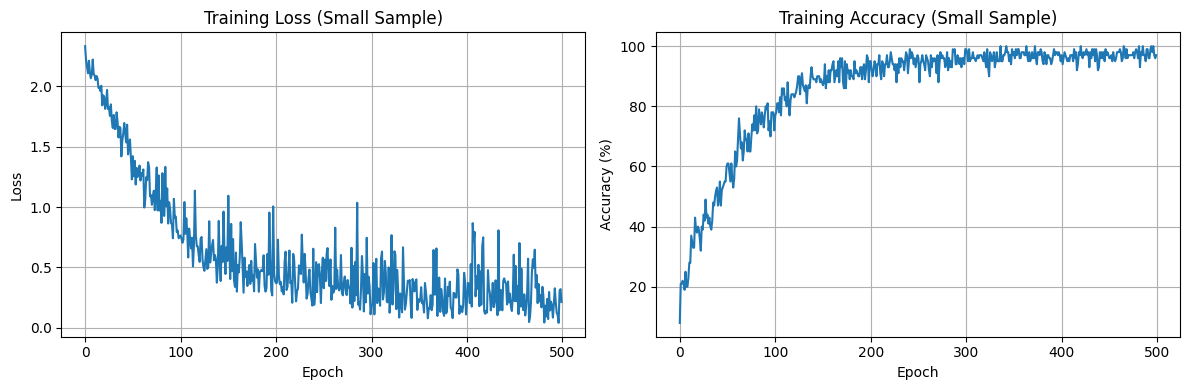


📊 Overfitting Test Results:
   Final Loss: 0.2132
   Final Accuracy: 97.00%
   ⚠️ Model learning but may need more epochs or different hyperparameters


In [12]:
#@title test overfitting
def test_overfitting(model, train_loader_small, test_loader_small, device, epochs=500):
    """Test if model can overfit to a small sample"""
    print("🔍 Testing model's ability to overfit small sample...")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        pbar = tqdm(train_loader_small, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        avg_loss = epoch_loss / len(train_loader_small)
        accuracy = 100. * correct / total
        
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss (Small Sample)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    ax2.plot(train_accs)
    ax2.set_title('Training Accuracy (Small Sample)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    final_loss = train_losses[-1]
    final_acc = train_accs[-1]
    
    print(f"\n📊 Overfitting Test Results:")
    print(f"   Final Loss: {final_loss:.4f}")
    print(f"   Final Accuracy: {final_acc:.2f}%")
    
    if final_loss < 0.1 and final_acc > 95:
        print("   ✅ Model can overfit successfully!")
    elif final_acc > 80:
        print("   ⚠️ Model learning but may need more epochs or different hyperparameters")
    else:
        print("   ❌ Model may have issues - check architecture or hyperparameters")
    
    return final_loss, final_acc

# Run overfitting test
print("\nCreating small sample dataset...")
train_loader_small, test_loader_small = get_small_sample_dataloaders(trainset, testset)

# Test overfitting
model_test = ShuffleNet(groups=3, num_classes=10)
test_loss, test_acc = test_overfitting(model_test, train_loader_small, test_loader_small, device)


In [14]:
#@title training setup
def setup_wandb(project_name="shufflenet-cifar10", experiment_name=None):
    """Initialize Weights & Biases logging"""
    
    config = {
        "architecture": "ShuffleNet",
        "dataset": "CIFAR-10",
        "groups": 3,
        "batch_size": 128,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "epochs": 100,
        "optimizer": "SGD",
        "scheduler": "StepLR",
        "step_size": 50,
        "gamma": 0.1
    }
    
    wandb.init(
        project=project_name,
        name=experiment_name,
        config=config,
        tags=["shufflenet", "cifar10", "pytorch"]
    )
    
    return config

# Initialize wandb (uncomment the line below when ready to log)
config = setup_wandb(experiment_name="shufflenet_test_run")
print("⚠️ Wandb setup ready - uncomment the line above to start logging")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/admin/.netrc
wandb: Currently logged in as: an-nd225432 (an-nd225432-hust) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


⚠️ Wandb setup ready - uncomment the line above to start logging


In [15]:
#@title training function
def train_shufflenet(model, trainloader, testloader, device, config, log_wandb=False):
    """Full training function with progress bars and logging"""
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                               lr=config['learning_rate'], 
                               momentum=config['momentum'], 
                               weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                              step_size=config['step_size'], 
                                              gamma=config['gamma'])
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'learning_rate': []
    }
    
    print(f"🚀 Starting training for {config['epochs']} epochs...")
    
    # Main training loop
    for epoch in range(config['epochs']):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Training progress bar
        train_pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{config["epochs"]} [Train]', leave=False)
        
        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            current_lr = optimizer.param_groups[0]['lr']
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%',
                'LR': f'{current_lr:.6f}'
            })
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(trainloader)
        train_accuracy = 100. * correct / total
        current_lr = optimizer.param_groups[0]['lr']
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        test_pbar = tqdm(testloader, desc=f'Epoch {epoch+1}/{config["epochs"]} [Test]', leave=False)
        
        with torch.no_grad():
            for inputs, targets in test_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                test_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
        
        # Calculate test metrics
        avg_test_loss = test_loss / len(testloader)
        test_accuracy = 100. * correct / total
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_accuracy)
        history['learning_rate'].append(current_lr)
        
        # Print epoch results
        print(f"Epoch {epoch+1:3d}/{config['epochs']:3d} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:6.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:6.2f}% | "
              f"LR: {current_lr:.6f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "test_loss": avg_test_loss,
                "test_accuracy": test_accuracy,
                "learning_rate": current_lr
            })
        
        # Step scheduler
        scheduler.step()
        
        # Early stopping check (optional)
        if test_accuracy > 95.0:
            print(f"🎉 Reached 95% test accuracy at epoch {epoch+1}!")
            break
    
    return model, history

print("✅ Training function ready!")

✅ Training function ready!


In [16]:
#@title Model Evaluation Functions
def evaluate_model_comprehensive(model, testloader, device):
    """Comprehensive model evaluation with all metrics"""
    print("\n" + "="*60)
    print("🔍 COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    # 1. Accuracy Metrics
    print("\n1️⃣ Accuracy Metrics:")
    accuracies = calculate_accuracy(model, testloader, device, top_k=(1, 5))
    print(f"   📊 Top-1 Accuracy: {accuracies[1]:.2f}%")
    print(f"   📊 Top-5 Accuracy: {accuracies[5]:.2f}%")
    
    # 2. Computational Complexity
    print("\n2️⃣ Computational Complexity:")
    model_cpu = model.cpu()  # Move to CPU for FLOP counting
    flops = count_flops(model_cpu)
    model = model.to(device)  # Move back to original device
    print(f"   🧮 FLOPs: {flops:,} ({flops/1e6:.2f} MFLOPs)")
    
    # 3. Inference Performance
    print("\n3️⃣ Inference Performance:")
    avg_latency = measure_inference_time(model, num_runs=100)
    throughput = 1000 / avg_latency
    print(f"   ⚡ Average Inference Time: {avg_latency:.2f} ms")
    print(f"   🚀 Throughput: {throughput:.2f} images/second")
    
    # 4. Model Statistics
    print("\n4️⃣ Model Statistics:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = total_params * 4 / 1024 / 1024
    
    print(f"   📈 Total Parameters: {total_params:,}")
    print(f"   🎯 Trainable Parameters: {trainable_params:,}")
    print(f"   💾 Model Size: {model_size_mb:.2f} MB (float32)")
    
    # 5. Efficiency Metrics
    print("\n5️⃣ Efficiency Metrics:")
    flops_per_param = flops / total_params
    accuracy_per_flop = accuracies[1] / (flops / 1e6)  # Accuracy per MFLOPs
    
    print(f"   ⚖️ FLOPs per Parameter: {flops_per_param:.2f}")
    print(f"   🎯 Accuracy per MFLOP: {accuracy_per_flop:.2f}")
    
    # Create evaluation summary
    eval_results = {
        'top1_accuracy': accuracies[1],
        'top5_accuracy': accuracies[5],
        'flops': flops,
        'flops_mflops': flops / 1e6,
        'inference_time_ms': avg_latency,
        'throughput_imgs_sec': throughput,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'model_size_mb': model_size_mb,
        'flops_per_param': flops_per_param,
        'accuracy_per_mflop': accuracy_per_flop
    }
    
    return eval_results

def plot_training_history(history):
    """Plot training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Training and Test Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
    ax2.set_title('Training and Test Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning rate plot
    ax3.plot(epochs, history['learning_rate'], 'g-', label='Learning Rate', linewidth=2)
    ax3.set_title('Learning Rate Schedule', fontsize=14)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Combined accuracy plot
    ax4.plot(epochs, history['train_acc'], 'b-', alpha=0.7, label='Train Accuracy')
    ax4.plot(epochs, history['test_acc'], 'r-', alpha=0.7, label='Test Accuracy')
    ax4.fill_between(epochs, history['train_acc'], alpha=0.3, color='blue')
    ax4.fill_between(epochs, history['test_acc'], alpha=0.3, color='red')
    ax4.set_title('Accuracy Comparison', fontsize=14)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def save_model_and_results(model, history, eval_results, filepath='shufflenet_cifar10.pth'):
    """Save model and all results"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_history': history,
        'evaluation_results': eval_results,
        'model_config': {
            'groups': 3,
            'num_classes': 10,
            'architecture': 'ShuffleNet'
        }
    }, filepath)
    print(f"💾 Model and results saved to: {filepath}")

print("✅ Evaluation functions ready!")

✅ Evaluation functions ready!


Running quick training test...
🧪 Running quick training test (5 epochs)...
   Using 1000 training samples and 200 test samples
🚀 Starting training for 5 epochs...


Epoch 1/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   1/  5 | Train Loss: 7.9831 | Train Acc:  10.10% | Test Loss: 2.5698 | Test Acc:   7.50% | LR: 0.010000


Epoch 2/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   2/  5 | Train Loss: 12.2961 | Train Acc:  14.20% | Test Loss: 3.8175 | Test Acc:  10.00% | LR: 0.010000


Epoch 3/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   3/  5 | Train Loss: 6.2614 | Train Acc:  14.00% | Test Loss: 5.4773 | Test Acc:  12.00% | LR: 0.010000


Epoch 4/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   4/  5 | Train Loss: 4.0091 | Train Acc:  19.20% | Test Loss: 2.7678 | Test Acc:  18.50% | LR: 0.005000


Epoch 5/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   5/  5 | Train Loss: 2.7840 | Train Acc:  24.20% | Test Loss: 2.2532 | Test Acc:  26.00% | LR: 0.005000

📊 Quick Test Results:
   Final Train Accuracy: 24.20%
   Final Test Accuracy: 26.00%


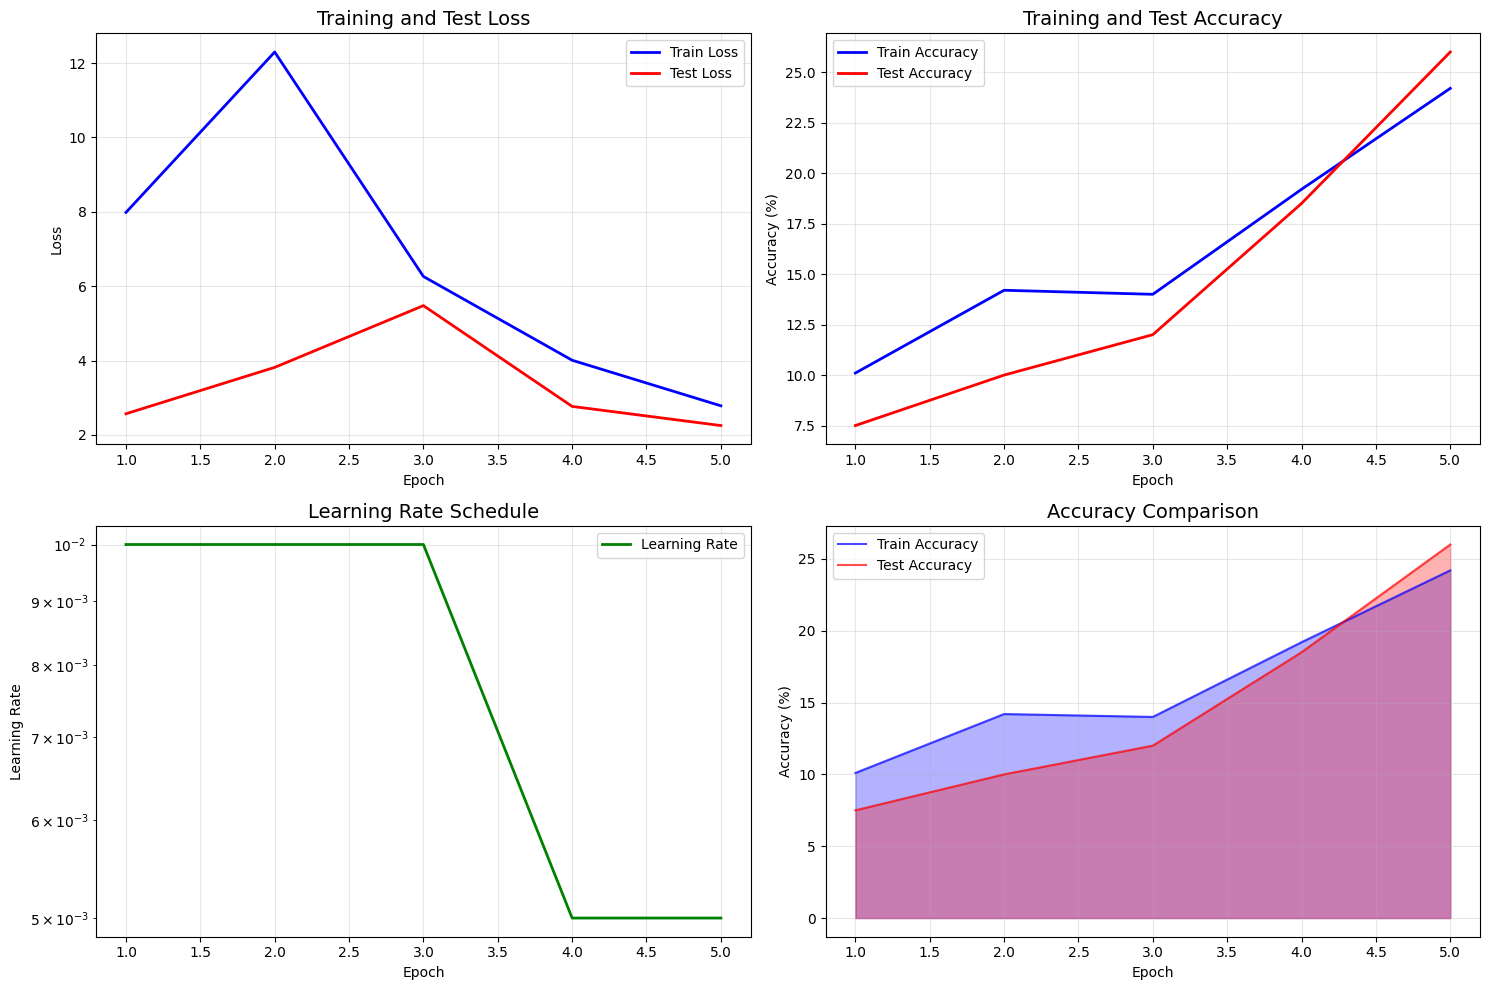

In [17]:
#@title quick test
def quick_training_test(epochs=5):
    """Quick training test with few epochs to verify everything works"""
    print(f"🧪 Running quick training test ({epochs} epochs)...")
    
    # Setup
    model = ShuffleNet(groups=3, num_classes=10)
    
    # Quick config
    quick_config = {
        "epochs": epochs,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "step_size": 3,
        "gamma": 0.5
    }
    
    # Use smaller dataloaders for quick test
    train_subset_indices = torch.randperm(len(trainset))[:1000]  # 1000 samples
    test_subset_indices = torch.randperm(len(testset))[:200]     # 200 samples
    
    train_subset = Subset(trainset, train_subset_indices)
    test_subset = Subset(testset, test_subset_indices)
    
    quick_trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    quick_testloader = DataLoader(test_subset, batch_size=64, shuffle=False)
    
    print(f"   Using {len(train_subset)} training samples and {len(test_subset)} test samples")
    
    # Train
    trained_model, history = train_shufflenet(model, quick_trainloader, quick_testloader, 
                                            device, quick_config, log_wandb=False)
    
    # Quick evaluation
    print(f"\n📊 Quick Test Results:")
    print(f"   Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"   Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
    
    # Plot quick results
    plot_training_history(history)
    
    return trained_model, history

# Run quick test
print("Running quick training test...")
quick_model, quick_history = quick_training_test(epochs=5)

✅ Full training pipeline ready!
🚀 Starting Full Training Pipeline...
Configuration:
   architecture: ShuffleNet
   dataset: CIFAR-10
   groups: 3
   batch_size: 128
   learning_rate: 0.1
   momentum: 0.9
   weight_decay: 0.0005
   epochs: 100
   optimizer: SGD
   scheduler: StepLR
   step_size: 50
   gamma: 0.1



⚠️ Wandb logging is disabled. Uncomment lines above to enable.
🎯 Training will take approximately 1-2 hours depending on your hardware.


Continue with full training? (y/n):  y



🏃‍♂️ STARTING FULL TRAINING
🚀 Starting training for 100 epochs...


Epoch 1/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   1/100 | Train Loss: 4.1503 | Train Acc:  27.99% | Test Loss: 1.6577 | Test Acc:  38.75% | LR: 0.100000


Epoch 2/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   2/100 | Train Loss: 1.5961 | Train Acc:  41.25% | Test Loss: 1.4901 | Test Acc:  45.46% | LR: 0.100000


Epoch 3/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   3/100 | Train Loss: 1.4360 | Train Acc:  47.71% | Test Loss: 1.3876 | Test Acc:  51.26% | LR: 0.100000


Epoch 4/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   4/100 | Train Loss: 1.3024 | Train Acc:  52.74% | Test Loss: 1.3476 | Test Acc:  53.08% | LR: 0.100000


Epoch 5/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   5/100 | Train Loss: 1.1722 | Train Acc:  58.22% | Test Loss: 1.1859 | Test Acc:  57.73% | LR: 0.100000


Epoch 6/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   6/100 | Train Loss: 1.0731 | Train Acc:  61.92% | Test Loss: 1.0670 | Test Acc:  61.63% | LR: 0.100000


Epoch 7/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   7/100 | Train Loss: 0.9998 | Train Acc:  64.64% | Test Loss: 1.1007 | Test Acc:  61.70% | LR: 0.100000


Epoch 8/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   8/100 | Train Loss: 0.9122 | Train Acc:  67.80% | Test Loss: 0.9349 | Test Acc:  67.56% | LR: 0.100000


Epoch 9/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   9/100 | Train Loss: 0.8279 | Train Acc:  71.20% | Test Loss: 0.9311 | Test Acc:  69.37% | LR: 0.100000


Epoch 10/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  10/100 | Train Loss: 0.7689 | Train Acc:  73.16% | Test Loss: 1.2171 | Test Acc:  60.87% | LR: 0.100000


Epoch 11/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  11/100 | Train Loss: 0.7212 | Train Acc:  74.91% | Test Loss: 0.7495 | Test Acc:  74.34% | LR: 0.100000


Epoch 12/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  12/100 | Train Loss: 0.6994 | Train Acc:  75.69% | Test Loss: 0.8010 | Test Acc:  73.29% | LR: 0.100000


Epoch 13/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  13/100 | Train Loss: 0.6735 | Train Acc:  76.64% | Test Loss: 1.2265 | Test Acc:  61.01% | LR: 0.100000


Epoch 14/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  14/100 | Train Loss: 0.6611 | Train Acc:  77.18% | Test Loss: 0.8205 | Test Acc:  72.00% | LR: 0.100000


Epoch 15/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  15/100 | Train Loss: 0.6384 | Train Acc:  78.21% | Test Loss: 0.7003 | Test Acc:  76.21% | LR: 0.100000


Epoch 16/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  16/100 | Train Loss: 0.6290 | Train Acc:  78.07% | Test Loss: 0.6691 | Test Acc:  76.85% | LR: 0.100000


Epoch 17/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  17/100 | Train Loss: 0.6197 | Train Acc:  78.65% | Test Loss: 1.0193 | Test Acc:  68.34% | LR: 0.100000


Epoch 18/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  18/100 | Train Loss: 0.6077 | Train Acc:  79.03% | Test Loss: 0.8011 | Test Acc:  72.78% | LR: 0.100000


Epoch 19/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  19/100 | Train Loss: 0.5967 | Train Acc:  79.40% | Test Loss: 0.8211 | Test Acc:  72.86% | LR: 0.100000


Epoch 20/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  20/100 | Train Loss: 0.5993 | Train Acc:  79.20% | Test Loss: 1.0462 | Test Acc:  67.55% | LR: 0.100000


Epoch 21/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  21/100 | Train Loss: 0.5839 | Train Acc:  79.90% | Test Loss: 0.7731 | Test Acc:  75.10% | LR: 0.100000


Epoch 22/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  22/100 | Train Loss: 0.5811 | Train Acc:  79.85% | Test Loss: 0.7507 | Test Acc:  74.99% | LR: 0.100000


Epoch 23/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  23/100 | Train Loss: 0.5737 | Train Acc:  80.10% | Test Loss: 0.6680 | Test Acc:  77.37% | LR: 0.100000


Epoch 24/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  24/100 | Train Loss: 0.5636 | Train Acc:  80.52% | Test Loss: 0.6832 | Test Acc:  76.74% | LR: 0.100000


Epoch 25/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  25/100 | Train Loss: 0.5591 | Train Acc:  80.57% | Test Loss: 0.8787 | Test Acc:  71.94% | LR: 0.100000


Epoch 26/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  26/100 | Train Loss: 0.5664 | Train Acc:  80.27% | Test Loss: 0.8547 | Test Acc:  72.39% | LR: 0.100000


Epoch 27/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  27/100 | Train Loss: 0.5554 | Train Acc:  80.91% | Test Loss: 0.7673 | Test Acc:  74.84% | LR: 0.100000


Epoch 28/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  28/100 | Train Loss: 0.5478 | Train Acc:  81.15% | Test Loss: 0.7956 | Test Acc:  74.31% | LR: 0.100000


Epoch 29/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  29/100 | Train Loss: 0.5596 | Train Acc:  80.64% | Test Loss: 0.8531 | Test Acc:  73.16% | LR: 0.100000


Epoch 30/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  30/100 | Train Loss: 0.5457 | Train Acc:  81.06% | Test Loss: 0.6132 | Test Acc:  78.86% | LR: 0.100000


Epoch 31/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  31/100 | Train Loss: 0.5452 | Train Acc:  81.09% | Test Loss: 0.7355 | Test Acc:  75.63% | LR: 0.100000


Epoch 32/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  32/100 | Train Loss: 0.5438 | Train Acc:  81.18% | Test Loss: 0.6987 | Test Acc:  76.10% | LR: 0.100000


Epoch 33/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  33/100 | Train Loss: 0.5456 | Train Acc:  81.10% | Test Loss: 0.6430 | Test Acc:  77.84% | LR: 0.100000


Epoch 34/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  34/100 | Train Loss: 0.5360 | Train Acc:  81.56% | Test Loss: 0.6729 | Test Acc:  76.80% | LR: 0.100000


Epoch 35/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  35/100 | Train Loss: 0.5275 | Train Acc:  81.86% | Test Loss: 0.7743 | Test Acc:  74.50% | LR: 0.100000


Epoch 36/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  36/100 | Train Loss: 0.5348 | Train Acc:  81.61% | Test Loss: 0.7485 | Test Acc:  75.48% | LR: 0.100000


Epoch 37/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  37/100 | Train Loss: 0.5276 | Train Acc:  81.63% | Test Loss: 0.7745 | Test Acc:  74.20% | LR: 0.100000


Epoch 38/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  38/100 | Train Loss: 0.5312 | Train Acc:  81.63% | Test Loss: 0.8788 | Test Acc:  72.20% | LR: 0.100000


Epoch 39/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  39/100 | Train Loss: 0.5339 | Train Acc:  81.51% | Test Loss: 0.6404 | Test Acc:  78.32% | LR: 0.100000


Epoch 40/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  40/100 | Train Loss: 0.5254 | Train Acc:  81.86% | Test Loss: 0.6600 | Test Acc:  78.00% | LR: 0.100000


Epoch 41/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  41/100 | Train Loss: 0.5219 | Train Acc:  81.86% | Test Loss: 0.7436 | Test Acc:  75.64% | LR: 0.100000


Epoch 42/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  42/100 | Train Loss: 0.5210 | Train Acc:  82.10% | Test Loss: 0.6668 | Test Acc:  78.03% | LR: 0.100000


Epoch 43/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  43/100 | Train Loss: 0.5261 | Train Acc:  81.79% | Test Loss: 0.7547 | Test Acc:  74.86% | LR: 0.100000


Epoch 44/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  44/100 | Train Loss: 0.5261 | Train Acc:  81.77% | Test Loss: 0.7010 | Test Acc:  76.75% | LR: 0.100000


Epoch 45/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  45/100 | Train Loss: 0.5127 | Train Acc:  82.34% | Test Loss: 0.8291 | Test Acc:  73.90% | LR: 0.100000


Epoch 46/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  46/100 | Train Loss: 0.5233 | Train Acc:  82.15% | Test Loss: 0.7282 | Test Acc:  76.18% | LR: 0.100000


Epoch 47/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  47/100 | Train Loss: 0.5116 | Train Acc:  82.49% | Test Loss: 0.8090 | Test Acc:  73.36% | LR: 0.100000


Epoch 48/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  48/100 | Train Loss: 0.5093 | Train Acc:  82.42% | Test Loss: 0.8676 | Test Acc:  72.35% | LR: 0.100000


Epoch 49/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  49/100 | Train Loss: 0.5110 | Train Acc:  82.44% | Test Loss: 0.8925 | Test Acc:  72.06% | LR: 0.100000


Epoch 50/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  50/100 | Train Loss: 0.5089 | Train Acc:  82.55% | Test Loss: 0.7413 | Test Acc:  76.00% | LR: 0.100000


Epoch 51/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 51/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  51/100 | Train Loss: 0.3530 | Train Acc:  88.05% | Test Loss: 0.3467 | Test Acc:  88.22% | LR: 0.010000


Epoch 52/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 52/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  52/100 | Train Loss: 0.2980 | Train Acc:  89.78% | Test Loss: 0.3236 | Test Acc:  88.56% | LR: 0.010000


Epoch 53/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 53/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  53/100 | Train Loss: 0.2721 | Train Acc:  90.75% | Test Loss: 0.3233 | Test Acc:  88.71% | LR: 0.010000


Epoch 54/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 54/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  54/100 | Train Loss: 0.2581 | Train Acc:  91.02% | Test Loss: 0.3165 | Test Acc:  89.05% | LR: 0.010000


Epoch 55/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 55/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  55/100 | Train Loss: 0.2460 | Train Acc:  91.54% | Test Loss: 0.3198 | Test Acc:  88.92% | LR: 0.010000


Epoch 56/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 56/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  56/100 | Train Loss: 0.2389 | Train Acc:  91.79% | Test Loss: 0.3259 | Test Acc:  88.93% | LR: 0.010000


Epoch 57/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 57/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  57/100 | Train Loss: 0.2277 | Train Acc:  92.24% | Test Loss: 0.3120 | Test Acc:  89.27% | LR: 0.010000


Epoch 58/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 58/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  58/100 | Train Loss: 0.2219 | Train Acc:  92.29% | Test Loss: 0.3122 | Test Acc:  89.38% | LR: 0.010000


Epoch 59/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 59/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  59/100 | Train Loss: 0.2171 | Train Acc:  92.57% | Test Loss: 0.3158 | Test Acc:  89.09% | LR: 0.010000


Epoch 60/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 60/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  60/100 | Train Loss: 0.2069 | Train Acc:  92.76% | Test Loss: 0.3123 | Test Acc:  89.45% | LR: 0.010000


Epoch 61/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 61/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  61/100 | Train Loss: 0.2107 | Train Acc:  92.61% | Test Loss: 0.3395 | Test Acc:  88.77% | LR: 0.010000


Epoch 62/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 62/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  62/100 | Train Loss: 0.2023 | Train Acc:  92.94% | Test Loss: 0.3258 | Test Acc:  88.85% | LR: 0.010000


Epoch 63/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 63/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  63/100 | Train Loss: 0.1986 | Train Acc:  93.06% | Test Loss: 0.3430 | Test Acc:  89.02% | LR: 0.010000


Epoch 64/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 64/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  64/100 | Train Loss: 0.1981 | Train Acc:  93.12% | Test Loss: 0.3279 | Test Acc:  89.19% | LR: 0.010000


Epoch 65/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 65/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  65/100 | Train Loss: 0.1954 | Train Acc:  93.25% | Test Loss: 0.3295 | Test Acc:  89.25% | LR: 0.010000


Epoch 66/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 66/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  66/100 | Train Loss: 0.1909 | Train Acc:  93.31% | Test Loss: 0.3355 | Test Acc:  88.90% | LR: 0.010000


Epoch 67/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 67/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  67/100 | Train Loss: 0.1920 | Train Acc:  93.34% | Test Loss: 0.3421 | Test Acc:  88.89% | LR: 0.010000


Epoch 68/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 68/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  68/100 | Train Loss: 0.1850 | Train Acc:  93.60% | Test Loss: 0.3490 | Test Acc:  88.62% | LR: 0.010000


Epoch 69/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 69/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  69/100 | Train Loss: 0.1859 | Train Acc:  93.35% | Test Loss: 0.3358 | Test Acc:  89.11% | LR: 0.010000


Epoch 70/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 70/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  70/100 | Train Loss: 0.1916 | Train Acc:  93.38% | Test Loss: 0.3333 | Test Acc:  89.10% | LR: 0.010000


Epoch 71/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 71/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  71/100 | Train Loss: 0.1811 | Train Acc:  93.76% | Test Loss: 0.3623 | Test Acc:  88.69% | LR: 0.010000


Epoch 72/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 72/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  72/100 | Train Loss: 0.1829 | Train Acc:  93.71% | Test Loss: 0.3400 | Test Acc:  89.12% | LR: 0.010000


Epoch 73/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 73/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  73/100 | Train Loss: 0.1845 | Train Acc:  93.49% | Test Loss: 0.3658 | Test Acc:  88.25% | LR: 0.010000


Epoch 74/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 74/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  74/100 | Train Loss: 0.1848 | Train Acc:  93.51% | Test Loss: 0.3510 | Test Acc:  89.23% | LR: 0.010000


Epoch 75/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 75/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  75/100 | Train Loss: 0.1797 | Train Acc:  93.76% | Test Loss: 0.3442 | Test Acc:  89.29% | LR: 0.010000


Epoch 76/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 76/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  76/100 | Train Loss: 0.1801 | Train Acc:  93.71% | Test Loss: 0.3555 | Test Acc:  88.77% | LR: 0.010000


Epoch 77/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 77/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  77/100 | Train Loss: 0.1825 | Train Acc:  93.48% | Test Loss: 0.3711 | Test Acc:  88.45% | LR: 0.010000


Epoch 78/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 78/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  78/100 | Train Loss: 0.1769 | Train Acc:  93.78% | Test Loss: 0.3535 | Test Acc:  89.33% | LR: 0.010000


Epoch 79/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 79/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  79/100 | Train Loss: 0.1864 | Train Acc:  93.36% | Test Loss: 0.3683 | Test Acc:  88.83% | LR: 0.010000


Epoch 80/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 80/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  80/100 | Train Loss: 0.1777 | Train Acc:  93.80% | Test Loss: 0.3389 | Test Acc:  89.22% | LR: 0.010000


Epoch 81/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 81/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  81/100 | Train Loss: 0.1821 | Train Acc:  93.44% | Test Loss: 0.3643 | Test Acc:  88.63% | LR: 0.010000


Epoch 82/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 82/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  82/100 | Train Loss: 0.1805 | Train Acc:  93.67% | Test Loss: 0.3568 | Test Acc:  88.91% | LR: 0.010000


Epoch 83/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 83/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  83/100 | Train Loss: 0.1745 | Train Acc:  93.95% | Test Loss: 0.3514 | Test Acc:  89.09% | LR: 0.010000


Epoch 84/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 84/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  84/100 | Train Loss: 0.1781 | Train Acc:  93.74% | Test Loss: 0.3814 | Test Acc:  87.93% | LR: 0.010000


Epoch 85/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 85/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  85/100 | Train Loss: 0.1768 | Train Acc:  93.71% | Test Loss: 0.3515 | Test Acc:  88.88% | LR: 0.010000


Epoch 86/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 86/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  86/100 | Train Loss: 0.1744 | Train Acc:  93.86% | Test Loss: 0.3568 | Test Acc:  88.85% | LR: 0.010000


Epoch 87/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 87/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  87/100 | Train Loss: 0.1758 | Train Acc:  93.82% | Test Loss: 0.3497 | Test Acc:  89.29% | LR: 0.010000


Epoch 88/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 88/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  88/100 | Train Loss: 0.1752 | Train Acc:  93.76% | Test Loss: 0.3529 | Test Acc:  88.77% | LR: 0.010000


Epoch 89/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 89/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  89/100 | Train Loss: 0.1777 | Train Acc:  93.71% | Test Loss: 0.3642 | Test Acc:  88.47% | LR: 0.010000


Epoch 90/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 90/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  90/100 | Train Loss: 0.1763 | Train Acc:  93.74% | Test Loss: 0.4130 | Test Acc:  87.63% | LR: 0.010000


Epoch 91/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 91/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  91/100 | Train Loss: 0.1744 | Train Acc:  93.94% | Test Loss: 0.3381 | Test Acc:  89.48% | LR: 0.010000


Epoch 92/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 92/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  92/100 | Train Loss: 0.1766 | Train Acc:  93.79% | Test Loss: 0.3857 | Test Acc:  87.88% | LR: 0.010000


Epoch 93/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 93/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  93/100 | Train Loss: 0.1726 | Train Acc:  93.94% | Test Loss: 0.3994 | Test Acc:  87.49% | LR: 0.010000


Epoch 94/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 94/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  94/100 | Train Loss: 0.1727 | Train Acc:  93.99% | Test Loss: 0.3768 | Test Acc:  88.22% | LR: 0.010000


Epoch 95/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 95/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  95/100 | Train Loss: 0.1716 | Train Acc:  93.96% | Test Loss: 0.3980 | Test Acc:  87.76% | LR: 0.010000


Epoch 96/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 96/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  96/100 | Train Loss: 0.1699 | Train Acc:  94.07% | Test Loss: 0.3740 | Test Acc:  88.41% | LR: 0.010000


Epoch 97/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 97/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  97/100 | Train Loss: 0.1706 | Train Acc:  94.03% | Test Loss: 0.3896 | Test Acc:  87.75% | LR: 0.010000


Epoch 98/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 98/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  98/100 | Train Loss: 0.1716 | Train Acc:  93.90% | Test Loss: 0.3524 | Test Acc:  88.86% | LR: 0.010000


Epoch 99/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 99/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  99/100 | Train Loss: 0.1710 | Train Acc:  93.94% | Test Loss: 0.3625 | Test Acc:  88.71% | LR: 0.010000


Epoch 100/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 100/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 100/100 | Train Loss: 0.1642 | Train Acc:  94.34% | Test Loss: 0.4386 | Test Acc:  86.60% | LR: 0.010000

🎉 Training completed!

🔍 COMPREHENSIVE MODEL EVALUATION

1️⃣ Accuracy Metrics:


Calculating accuracy:   0%|          | 0/79 [00:00<?, ?it/s]

   📊 Top-1 Accuracy: 86.60%
   📊 Top-5 Accuracy: 99.44%

2️⃣ Computational Complexity:
   🧮 FLOPs: 38,310,144 (38.31 MFLOPs)

3️⃣ Inference Performance:
   ⚡ Average Inference Time: 3.01 ms
   🚀 Throughput: 332.68 images/second

4️⃣ Model Statistics:
   📈 Total Parameters: 862,480
   🎯 Trainable Parameters: 862,480
   💾 Model Size: 3.29 MB (float32)

5️⃣ Efficiency Metrics:
   ⚖️ FLOPs per Parameter: 44.42
   🎯 Accuracy per MFLOP: 2.26


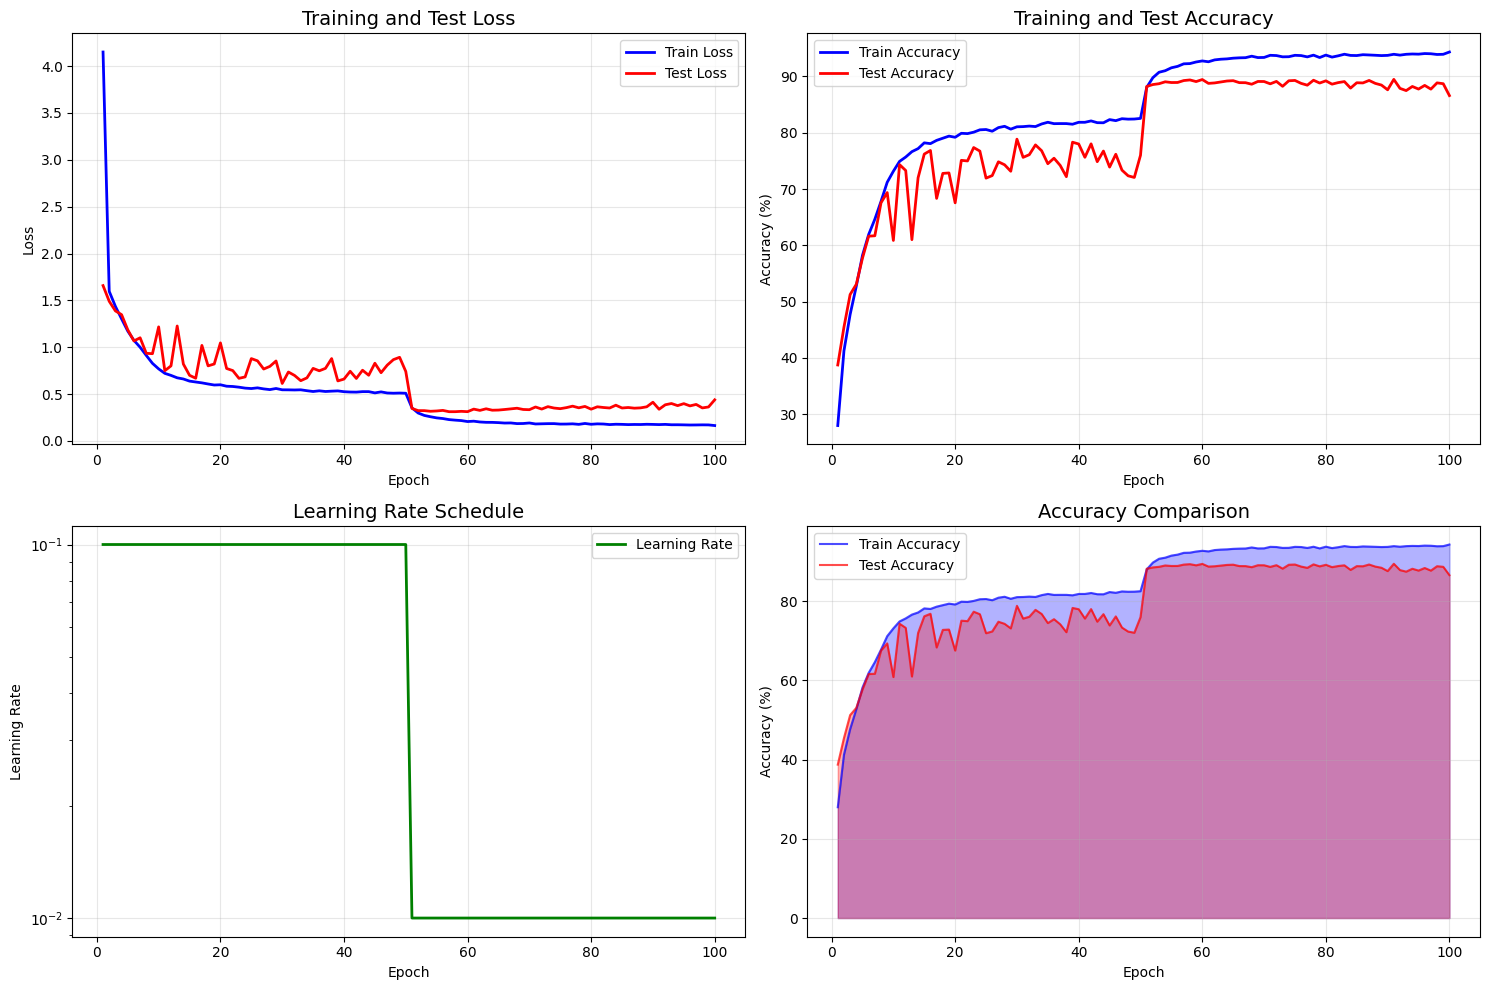

accuracy_per_mflop,▁
flops,▁
flops_mflops,▁
flops_per_param,▁
inference_time_ms,▁
model_size_mb,▁
throughput_imgs_sec,▁
top1_accuracy,▁
top5_accuracy,▁
total_parameters,▁
+1,...


💾 Model and results saved to: shufflenet_cifar10.pth


(ShuffleNet(
   (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (stage2): Sequential(
     (0): ShuffleBlock(
       (conv1): Conv2d(24, 54, kernel_size=(1, 1), stride=(1, 1), groups=3, bias=False)
       (bn1): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shuffle): ChannelShuffle()
       (conv2): Conv2d(54, 54, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=54, bias=False)
       (bn2): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(54, 216, kernel_size=(1, 1), stride=(1, 1), groups=3, bias=False)
       (bn3): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential(
         (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
       )
       (relu): ReLU(inplace=T

In [18]:
#@title full training
def run_full_training():
    """Run the complete training pipeline"""
    
    print("🚀 Starting Full Training Pipeline...")
    print("="*60)
    
    # Initialize fresh model
    model = ShuffleNet(groups=3, num_classes=10)
    
    # Full training config
    full_config = {
        "architecture": "ShuffleNet",
        "dataset": "CIFAR-10",
        "groups": 3,
        "batch_size": 128,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "epochs": 100,
        "optimizer": "SGD",
        "scheduler": "StepLR",
        "step_size": 50,
        "gamma": 0.1
    }
    
    print("Configuration:")
    for key, value in full_config.items():
        print(f"   {key}: {value}")
    
    # Uncomment the next two lines to enable wandb logging
    wandb.init(project="shufflenet-cifar10", config=full_config, 
              tags=["shufflenet", "cifar10", "full_training"])
    
    print(f"\n⚠️ Wandb logging is disabled. Uncomment lines above to enable.")
    print(f"🎯 Training will take approximately 1-2 hours depending on your hardware.")
    
    # Ask for confirmation
    response = input("Continue with full training? (y/n): ")
    if response.lower() != 'y':
        print("Training cancelled.")
        return None, None, None
    
    # Start training
    print("\n" + "="*60)
    print("🏃‍♂️ STARTING FULL TRAINING")
    print("="*60)
    
    trained_model, history = train_shufflenet(
        model, trainloader, testloader, device, full_config, log_wandb=False
    )
    
    print("\n🎉 Training completed!")
    
    # Comprehensive evaluation
    eval_results = evaluate_model_comprehensive(trained_model, testloader, device)
    
    # Plot training history
    plot_training_history(history)
    
    # Log final results to wandb if enabled
    if wandb.run is not None:
        wandb.log(eval_results)
        wandb.finish()
    
    # Save everything
    save_model_and_results(trained_model, history, eval_results)
    
    return trained_model, history, eval_results

print("✅ Full training pipeline ready!")
run_full_training()

## RepVGG 

In [20]:
# Cell 1: Import Libraries and Setup

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import time
import numpy as np
from tqdm.notebook import tqdm
import wandb
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import shutil

torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for checkpoints
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('best_models', exist_ok=True)

print("✅ Setup completed!")
print("📁 Created directories: checkpoints/, best_models/")

Using device: cuda
✅ Setup completed!
📁 Created directories: checkpoints/, best_models/


In [21]:
# Cell 2: RepVGG Architecture

class RepVGGBlock(nn.Module):
    """RepVGG Block with 3x3, 1x1 convolutions and identity connection"""
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                 groups=1, deploy=False, use_se=False):
        super(RepVGGBlock, self).__init__()
        
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # For deployment (inference) - single 3x3 conv
        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                       kernel_size=kernel_size, stride=stride, padding=padding,
                                       groups=groups, bias=True)
        else:
            # Training mode - multiple branches
            # 3x3 convolution branch
            self.rbr_3x3 = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                         kernel_size=kernel_size, stride=stride, padding=padding,
                         groups=groups, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
            # 1x1 convolution branch
            self.rbr_1x1 = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                         kernel_size=1, stride=stride, padding=0,
                         groups=groups, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
            # Identity branch (only when input and output channels are same and stride=1)
            self.rbr_identity = nn.BatchNorm2d(in_channels) if (
                out_channels == in_channels and stride == 1) else None
        
        # SE block (optional)
        self.se = None
        if use_se:
            self.se = SEBlock(out_channels)
            
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        if hasattr(self, 'rbr_reparam'):
            # Deployment mode
            return self.act(self.rbr_reparam(x))
        
        # Training mode
        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(x)
        
        out = self.rbr_3x3(x) + self.rbr_1x1(x) + id_out
        
        if self.se is not None:
            out = self.se(out)
            
        return self.act(out)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class RepVGG(nn.Module):
    """RepVGG for CIFAR-10"""
    
    def __init__(self, num_blocks, num_classes=10, width_multiplier=None, 
                 override_groups_map=None, deploy=False, use_se=False):
        super(RepVGG, self).__init__()
        
        # Default width multipliers for different RepVGG variants
        if width_multiplier is None:
            width_multiplier = [0.75, 0.75, 0.75, 2.5]  # RepVGG-A0 config
            
        self.deploy = deploy
        self.override_groups_map = override_groups_map or {}
        self.use_se = use_se
        
        # Calculate channel numbers
        self.in_planes = min(64, int(64 * width_multiplier[0]))
        
        # Stage 0: Initial convolution (modified for CIFAR-10)
        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes,
                                kernel_size=3, stride=1, padding=1, deploy=self.deploy)
        
        # Stage 1-4
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        
        # Global average pooling and classifier
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)
        
        self._initialize_weights()

    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.in_planes, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes,
                                    kernel_size=3, stride=stride, padding=1, groups=cur_groups,
                                    deploy=self.deploy, use_se=self.use_se))
            self.in_planes = planes
        return nn.Sequential(*blocks)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def create_RepVGG_A0(num_classes=10, deploy=False, use_se=False):
    """Create RepVGG-A0 model"""
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_classes,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], deploy=deploy, use_se=use_se)

def create_RepVGG_A1(num_classes=10, deploy=False, use_se=False):
    """Create RepVGG-A1 model"""
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_classes,
                  width_multiplier=[1, 1, 1, 2.5], deploy=deploy, use_se=use_se)

def create_RepVGG_A2(num_classes=10, deploy=False, use_se=False):
    """Create RepVGG-A2 model"""
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_classes,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], deploy=deploy, use_se=use_se)

def create_RepVGG_B0(num_classes=10, deploy=False, use_se=False):
    """Create RepVGG-B0 model"""
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=num_classes,
                  width_multiplier=[1, 1, 1, 2.5], deploy=deploy, use_se=use_se)

print("✅ RepVGG architecture defined successfully!")
print("📋 Available models: RepVGG-A0, A1, A2, B0")

✅ RepVGG architecture defined successfully!
📋 Available models: RepVGG-A0, A1, A2, B0


In [22]:
# Cell 3: Test Model with Dummy Data
# ========================================
def test_repvgg_shapes():
    """Test RepVGG models with dummy data to verify input/output shapes"""
    print("Testing RepVGG models with dummy data...")
    
    # Test different RepVGG variants
    models_to_test = {
        'RepVGG-A0': create_RepVGG_A0(),
        'RepVGG-A1': create_RepVGG_A1(),
        'RepVGG-B0': create_RepVGG_B0(),
    }
    
    test_cases = [
        (1, 3, 32, 32),   # Single image
        (8, 3, 32, 32),   # Small batch
        (32, 3, 32, 32),  # Medium batch
    ]
    
    for model_name, model in models_to_test.items():
        print(f"\n🔍 Testing {model_name}:")
        model.eval()
        
        for batch_size, channels, height, width in test_cases:
            print(f"   📊 Input shape: ({batch_size}, {channels}, {height}, {width})")
            
            # Create dummy input
            dummy_input = torch.randn(batch_size, channels, height, width)
            
            # Forward pass
            with torch.no_grad():
                output = model(dummy_input)
            
            print(f"      Output shape: {output.shape}")
            assert output.shape == (batch_size, 10), f"Wrong output shape: {output.shape}"
            print("      ✅ Shape test passed!")
        
        # Model statistics
        total_params = sum(p.numel() for p in model.parameters())
        print(f"   📈 Parameters: {total_params:,} ({total_params/1e6:.2f}M)")
    
    return models_to_test['RepVGG-A0']  # Return A0 for further testing

# Run the test
test_model = test_repvgg_shapes()

Testing RepVGG models with dummy data...

🔍 Testing RepVGG-A0:
   📊 Input shape: (1, 3, 32, 32)
      Output shape: torch.Size([1, 10])
      ✅ Shape test passed!
   📊 Input shape: (8, 3, 32, 32)
      Output shape: torch.Size([8, 10])
      ✅ Shape test passed!
   📊 Input shape: (32, 3, 32, 32)
      Output shape: torch.Size([32, 10])
      ✅ Shape test passed!
   📈 Parameters: 7,840,778 (7.84M)

🔍 Testing RepVGG-A1:
   📊 Input shape: (1, 3, 32, 32)
      Output shape: torch.Size([1, 10])
      ✅ Shape test passed!
   📊 Input shape: (8, 3, 32, 32)
      Output shape: torch.Size([8, 10])
      ✅ Shape test passed!
   📊 Input shape: (32, 3, 32, 32)
      Output shape: torch.Size([32, 10])
      ✅ Shape test passed!
   📈 Parameters: 12,824,074 (12.82M)

🔍 Testing RepVGG-B0:
   📊 Input shape: (1, 3, 32, 32)
      Output shape: torch.Size([1, 10])
      ✅ Shape test passed!
   📊 Input shape: (8, 3, 32, 32)
      Output shape: torch.Size([8, 10])
      ✅ Shape test passed!
   📊 Input shape:

In [23]:
# Cell 4: Utility Functions for Evaluation
# ========================================
def count_flops(model, input_size=(1, 3, 32, 32)):
    """Count FLOPs for the model"""
    def flop_count(module, input, output):
        if isinstance(module, nn.Conv2d):
            output_elements = output.nelement()
            kernel_flops = module.kernel_size[0] * module.kernel_size[1] * module.in_channels // module.groups
            flops = output_elements * kernel_flops
            module.__flops__ += flops
        elif isinstance(module, nn.Linear):
            flops = module.in_features * module.out_features
            module.__flops__ += flops

    model.eval()
    
    # Register hooks
    handles = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            module.__flops__ = 0
            handle = module.register_forward_hook(flop_count)
            handles.append(handle)
    
    # Forward pass
    input_tensor = torch.randn(input_size).to(next(model.parameters()).device)
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Calculate total FLOPs
    total_flops = 0
    for module in model.modules():
        if hasattr(module, '__flops__'):
            total_flops += module.__flops__
    
    # Remove hooks
    for handle in handles:
        handle.remove()
    
    return total_flops

def measure_inference_time(model, input_size=(1, 3, 32, 32), num_runs=100):
    """Measure inference latency"""
    model.eval()
    device = next(model.parameters()).device
    
    # Warmup
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)
    
    # Measure time
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_time = time.time()
    
    for _ in range(num_runs):
        with torch.no_grad():
            _ = model(dummy_input)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    return avg_time * 1000  # Return in milliseconds

def calculate_accuracy(model, dataloader, device, top_k=(1, 5)):
    """Calculate Top-1 and Top-5 accuracy"""
    model.eval()
    correct = {k: 0 for k in top_k}
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Calculating accuracy", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # Get top-k predictions
            _, pred = outputs.topk(max(top_k), dim=1, largest=True, sorted=True)
            
            total += targets.size(0)
            
            for k in top_k:
                correct_k = pred[:, :k].eq(targets.view(-1, 1).expand_as(pred[:, :k]))
                correct[k] += correct_k.sum().item()
    
    accuracies = {k: 100. * correct[k] / total for k in top_k}
    return accuracies

def save_checkpoint(model, optimizer, scheduler, epoch, loss, accuracy, 
                   filepath, is_best=False, config=None):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss': loss,
        'accuracy': accuracy,
        'config': config
    }
    
    torch.save(checkpoint, filepath)
    
    if is_best:
        best_path = filepath.replace('checkpoints/', 'best_models/').replace('.pth', '_best.pth')
        shutil.copyfile(filepath, best_path)
        print(f"💫 New best model saved: {best_path}")

def load_checkpoint(model, optimizer, scheduler, filepath):
    """Load model checkpoint"""
    checkpoint = torch.load(filepath, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    return checkpoint['epoch'], checkpoint['loss'], checkpoint['accuracy']

print("✅ Utility functions with checkpoint support defined successfully!")

✅ Utility functions with checkpoint support defined successfully!


In [24]:
# Cell 5: Data Loading and Preprocessing
# ========================================
def get_cifar10_dataloaders(batch_size=128, num_workers=2):
    """Load CIFAR-10 dataset with proper preprocessing"""
    
    # Data preprocessing with stronger augmentation for RepVGG
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        transforms.RandomErasing(p=0.1)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                           num_workers=num_workers, pin_memory=True)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, pin_memory=True)
    
    return trainloader, testloader, trainset, testset

def get_small_sample_dataloaders(trainset, testset, train_samples=100, test_samples=50, batch_size=32):
    """Create small sample dataloaders for overfitting test"""
    train_indices = torch.randperm(len(trainset))[:train_samples]
    test_indices = torch.randperm(len(testset))[:test_samples]
    
    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)
    
    train_loader_small = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader_small = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader_small, test_loader_small

# Load data
print("Loading CIFAR-10 dataset...")
trainloader, testloader, trainset, testset = get_cifar10_dataloaders()

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"✅ Dataset loaded successfully!")
print(f"   Training samples: {len(trainset)}")
print(f"   Test samples: {len(testset)}")
print(f"   Classes: {classes}")

Loading CIFAR-10 dataset...
✅ Dataset loaded successfully!
   Training samples: 50000
   Test samples: 10000
   Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Creating small sample dataset...
🔍 Testing RepVGG's ability to overfit small sample...


Epoch 1/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss = 2.2300, Accuracy = 13.00%


Epoch 6/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss = 2.2819, Accuracy = 13.00%


Epoch 11/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss = 2.2557, Accuracy = 13.00%


Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: Loss = 2.1669, Accuracy = 17.00%


Epoch 21/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25: Loss = 2.1269, Accuracy = 22.00%


Epoch 26/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30: Loss = 2.2471, Accuracy = 15.00%


Epoch 31/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35: Loss = 2.1802, Accuracy = 19.00%


Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40: Loss = 2.2548, Accuracy = 15.00%


Epoch 41/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45: Loss = 2.1942, Accuracy = 19.00%


Epoch 46/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50: Loss = 2.2239, Accuracy = 16.00%


Epoch 51/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55: Loss = 2.2254, Accuracy = 17.00%


Epoch 56/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60: Loss = 1.9933, Accuracy = 22.00%


Epoch 61/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65: Loss = 2.3638, Accuracy = 15.00%


Epoch 66/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70: Loss = 2.1689, Accuracy = 25.00%


Epoch 71/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75: Loss = 1.9950, Accuracy = 27.00%


Epoch 76/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80: Loss = 2.1074, Accuracy = 19.00%


Epoch 81/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85: Loss = 2.0304, Accuracy = 19.00%


Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90: Loss = 1.9744, Accuracy = 26.00%


Epoch 91/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95: Loss = 1.9906, Accuracy = 25.00%


Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100: Loss = 2.1679, Accuracy = 23.00%


Epoch 101/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105: Loss = 2.0088, Accuracy = 28.00%


Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110: Loss = 2.0045, Accuracy = 26.00%


Epoch 111/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115: Loss = 1.8885, Accuracy = 29.00%


Epoch 116/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120: Loss = 1.9062, Accuracy = 31.00%


Epoch 121/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125: Loss = 1.7327, Accuracy = 36.00%


Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130: Loss = 1.8536, Accuracy = 33.00%


Epoch 131/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135: Loss = 1.8010, Accuracy = 35.00%


Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140: Loss = 1.8537, Accuracy = 28.00%


Epoch 141/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145: Loss = 1.8391, Accuracy = 31.00%


Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150: Loss = 1.7235, Accuracy = 40.00%


Epoch 151/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155: Loss = 1.6917, Accuracy = 40.00%


Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160: Loss = 1.8083, Accuracy = 40.00%


Epoch 161/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165: Loss = 1.9098, Accuracy = 32.00%


Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170: Loss = 1.6657, Accuracy = 49.00%


Epoch 171/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175: Loss = 1.5902, Accuracy = 45.00%


Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180: Loss = 1.7040, Accuracy = 45.00%


Epoch 181/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185: Loss = 1.6630, Accuracy = 41.00%


Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 189/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190: Loss = 1.7047, Accuracy = 47.00%


Epoch 191/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 192/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 193/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195: Loss = 1.5459, Accuracy = 41.00%


Epoch 196/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 197/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 198/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 199/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200: Loss = 1.6534, Accuracy = 46.00%


Epoch 201/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 203/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205: Loss = 1.8214, Accuracy = 39.00%


Epoch 206/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 207/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 209/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210: Loss = 1.5788, Accuracy = 41.00%


Epoch 211/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 213/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215: Loss = 1.3306, Accuracy = 38.00%


Epoch 216/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 217/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 219/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220: Loss = 1.4030, Accuracy = 52.00%


Epoch 221/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 223/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225: Loss = 1.3604, Accuracy = 53.00%


Epoch 226/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 227/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 228/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 229/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230: Loss = 1.3573, Accuracy = 55.00%


Epoch 231/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 233/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235: Loss = 1.2887, Accuracy = 51.00%


Epoch 236/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 237/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 238/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 239/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240: Loss = 1.3525, Accuracy = 57.00%


Epoch 241/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 243/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245: Loss = 1.2749, Accuracy = 56.00%


Epoch 246/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 247/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 249/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250: Loss = 1.6257, Accuracy = 56.00%


Epoch 251/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 253/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255: Loss = 1.7384, Accuracy = 57.00%


Epoch 256/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 257/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 259/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260: Loss = 1.1405, Accuracy = 54.00%


Epoch 261/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 263/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265: Loss = 1.2971, Accuracy = 56.00%


Epoch 266/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 267/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 268/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 269/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270: Loss = 1.0908, Accuracy = 56.00%


Epoch 271/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 272/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 273/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275: Loss = 1.0797, Accuracy = 58.00%


Epoch 276/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 277/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 279/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280: Loss = 1.2968, Accuracy = 54.00%


Epoch 281/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 282/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 283/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285: Loss = 1.4418, Accuracy = 54.00%


Epoch 286/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 287/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 289/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290: Loss = 1.3929, Accuracy = 64.00%


Epoch 291/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 293/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295: Loss = 1.2903, Accuracy = 60.00%


Epoch 296/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 297/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 299/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300: Loss = 1.1285, Accuracy = 64.00%


Epoch 301/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 303/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 305/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 305: Loss = 1.0841, Accuracy = 60.00%


Epoch 306/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 307/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 309/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 310: Loss = 1.5281, Accuracy = 61.00%


Epoch 311/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 313/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 315/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 315: Loss = 1.2828, Accuracy = 61.00%


Epoch 316/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 317/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 319/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 320: Loss = 1.1333, Accuracy = 69.00%


Epoch 321/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 323/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 324/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 325/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 325: Loss = 1.0267, Accuracy = 65.00%


Epoch 326/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 327/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 328/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 329/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 330: Loss = 0.9717, Accuracy = 67.00%


Epoch 331/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 332/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 333/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 335/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 335: Loss = 0.9757, Accuracy = 69.00%


Epoch 336/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 337/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 338/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 339/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 340: Loss = 0.8829, Accuracy = 70.00%


Epoch 341/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 342/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 343/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 345/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 345: Loss = 1.1499, Accuracy = 65.00%


Epoch 346/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 347/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 348/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 349/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 350: Loss = 1.2399, Accuracy = 70.00%


Epoch 351/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 353/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 355/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 355: Loss = 0.9862, Accuracy = 63.00%


Epoch 356/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 357/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 359/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 360/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 360: Loss = 0.8438, Accuracy = 71.00%


Epoch 361/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 363/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 365/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 365: Loss = 0.7606, Accuracy = 71.00%


Epoch 366/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 367/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 368/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 369/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 370: Loss = 0.8338, Accuracy = 72.00%


Epoch 371/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 373/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 375/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 375: Loss = 1.0855, Accuracy = 66.00%


Epoch 376/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 377/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 378/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 379/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 380: Loss = 0.9395, Accuracy = 71.00%


Epoch 381/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 383/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 385/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 385: Loss = 0.8752, Accuracy = 78.00%


Epoch 386/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 387/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 389/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 390/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 390: Loss = 1.1349, Accuracy = 79.00%


Epoch 391/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 393/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 395/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 395: Loss = 1.2746, Accuracy = 72.00%


Epoch 396/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 397/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 398/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 399/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 400: Loss = 0.7626, Accuracy = 80.00%


Epoch 401/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 403/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 405/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 405: Loss = 0.9492, Accuracy = 74.00%


Epoch 406/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 407/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 408/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 409/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 410: Loss = 1.0557, Accuracy = 70.00%


Epoch 411/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 413/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 415/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 415: Loss = 1.1014, Accuracy = 69.00%


Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 417/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 418/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 419/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 420: Loss = 1.1006, Accuracy = 75.00%


Epoch 421/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 423/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 425/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 425: Loss = 0.6575, Accuracy = 80.00%


Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 427/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 428/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 429/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 430: Loss = 1.0927, Accuracy = 68.00%


Epoch 431/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 433/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 435/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 435: Loss = 0.5489, Accuracy = 83.00%


Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 437/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 438/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 439/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 440: Loss = 0.8251, Accuracy = 85.00%


Epoch 441/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 443/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 444/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 445/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 445: Loss = 0.8556, Accuracy = 82.00%


Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 447/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 448/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 449/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 450: Loss = 0.7025, Accuracy = 73.00%


Epoch 451/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 452/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 453/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 455/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 455: Loss = 0.9005, Accuracy = 74.00%


Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 457/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 458/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 459/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 460: Loss = 0.6090, Accuracy = 81.00%


Epoch 461/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 463/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 465/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 465: Loss = 0.8129, Accuracy = 78.00%


Epoch 466/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 467/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 468/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 469/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 470: Loss = 0.7256, Accuracy = 82.00%


Epoch 471/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 472/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 473/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 475/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 475: Loss = 0.5696, Accuracy = 83.00%


Epoch 476/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 477/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 478/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 479/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 480: Loss = 0.5757, Accuracy = 82.00%


Epoch 481/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 482/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 483/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 485/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 485: Loss = 0.7604, Accuracy = 80.00%


Epoch 486/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 487/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 488/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 489/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 490: Loss = 0.9624, Accuracy = 77.00%


Epoch 491/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 493/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 495/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 495: Loss = 0.7307, Accuracy = 82.00%


Epoch 496/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 497/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 498/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 499/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 500: Loss = 0.5040, Accuracy = 84.00%


Epoch 501/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 503/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 505/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 505: Loss = 0.7348, Accuracy = 79.00%


Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 507/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 508/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 509/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 510: Loss = 0.5162, Accuracy = 89.00%


Epoch 511/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 513/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 515/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 515: Loss = 1.0938, Accuracy = 75.00%


Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 517/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 518/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 519/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 520/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 520: Loss = 0.4930, Accuracy = 84.00%


Epoch 521/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 523/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 525/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 525: Loss = 0.7562, Accuracy = 76.00%


Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 527/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 528/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 529/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 530: Loss = 0.7846, Accuracy = 84.00%


Epoch 531/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 532/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 533/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 535/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 535: Loss = 0.8039, Accuracy = 73.00%


Epoch 536/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 537/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 538/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 539/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 540: Loss = 0.5292, Accuracy = 88.00%


Epoch 541/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 543/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 545/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 545: Loss = 0.6985, Accuracy = 79.00%


Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 547/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 548/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 549/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 550: Loss = 0.9063, Accuracy = 88.00%


Epoch 551/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 553/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 554/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 555/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 555: Loss = 0.6707, Accuracy = 82.00%


Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 557/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 558/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 559/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 560/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 560: Loss = 0.9095, Accuracy = 82.00%


Epoch 561/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 563/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 564/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 565/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 565: Loss = 0.3961, Accuracy = 89.00%


Epoch 566/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 567/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 568/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 569/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 570: Loss = 0.5690, Accuracy = 84.00%


Epoch 571/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 572/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 573/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 575/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 575: Loss = 0.5490, Accuracy = 88.00%


Epoch 576/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 577/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 578/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 579/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 580: Loss = 0.6676, Accuracy = 80.00%


Epoch 581/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 583/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 584/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 585/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 585: Loss = 0.4189, Accuracy = 91.00%


Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 587/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 588/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 589/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 590: Loss = 0.5224, Accuracy = 89.00%


Epoch 591/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 593/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 595/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 595: Loss = 0.4390, Accuracy = 88.00%


Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 597/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 598/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 599/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 600: Loss = 0.4583, Accuracy = 88.00%


Epoch 601/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 603/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 605/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 605: Loss = 0.7304, Accuracy = 82.00%


Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 607/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 608/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 609/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 610: Loss = 0.3363, Accuracy = 87.00%


Epoch 611/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 613/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 615/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 615: Loss = 0.3403, Accuracy = 90.00%


Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 617/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 618/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 619/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 620/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 620: Loss = 0.2442, Accuracy = 90.00%


Epoch 621/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 623/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 625/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 625: Loss = 0.4020, Accuracy = 88.00%


Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 627/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 628/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 629/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 630/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 630: Loss = 0.5459, Accuracy = 86.00%


Epoch 631/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 633/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 635/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 635: Loss = 0.2219, Accuracy = 94.00%


Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 637/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 638/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 639/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 640/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 640: Loss = 0.4170, Accuracy = 92.00%


Epoch 641/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 643/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 645/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 645: Loss = 0.6387, Accuracy = 89.00%


Epoch 646/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 647/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 648/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 649/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 650/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 650: Loss = 0.4151, Accuracy = 87.00%


Epoch 651/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 653/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 655/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 655: Loss = 0.7138, Accuracy = 86.00%


Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 657/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 658/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 659/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 660/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 660: Loss = 0.5148, Accuracy = 89.00%


Epoch 661/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 663/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 665/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 665: Loss = 0.3325, Accuracy = 90.00%


Epoch 666/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 667/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 668/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 669/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 670/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 670: Loss = 0.2025, Accuracy = 96.00%


Epoch 671/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 672/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 673/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 675/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 675: Loss = 0.4315, Accuracy = 88.00%


Epoch 676/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 677/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 678/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 679/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 680/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 680: Loss = 0.2000, Accuracy = 95.00%


Epoch 681/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 683/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 685/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 685: Loss = 0.5635, Accuracy = 93.00%


Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 687/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 689/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 690/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 690: Loss = 0.6284, Accuracy = 91.00%


Epoch 691/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 693/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 695/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 695: Loss = 0.8450, Accuracy = 89.00%


Epoch 696/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 697/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 699/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 700/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 700: Loss = 0.4489, Accuracy = 89.00%


Epoch 701/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 703/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 705/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 705: Loss = 0.7806, Accuracy = 94.00%


Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 707/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 709/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 710/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 710: Loss = 0.7779, Accuracy = 94.00%


Epoch 711/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 713/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 715/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 715: Loss = 0.7548, Accuracy = 88.00%


Epoch 716/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 717/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 719/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 720/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 720: Loss = 0.2511, Accuracy = 90.00%


Epoch 721/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 723/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 724/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 725/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 725: Loss = 0.5791, Accuracy = 87.00%


Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 727/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 728/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 729/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 730/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 730: Loss = 0.8027, Accuracy = 87.00%


Epoch 731/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 732/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 733/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 735/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 735: Loss = 0.4368, Accuracy = 89.00%


Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 737/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 739/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 740/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 740: Loss = 0.2659, Accuracy = 97.00%


Epoch 741/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 743/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 745/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 745: Loss = 0.3599, Accuracy = 92.00%


Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 747/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 749/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 750/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 750: Loss = 0.2690, Accuracy = 93.00%


Epoch 751/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 752/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 753/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 755/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 755: Loss = 0.3618, Accuracy = 86.00%


Epoch 756/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 757/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 759/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 760/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 760: Loss = 0.6918, Accuracy = 94.00%


Epoch 761/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 762/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 763/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 764/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 765/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 765: Loss = 0.5989, Accuracy = 93.00%


Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 767/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 768/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 769/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 770/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 770: Loss = 0.1412, Accuracy = 97.00%


Epoch 771/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 772/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 773/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 775/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 775: Loss = 0.5740, Accuracy = 95.00%


Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 777/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 778/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 779/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 780/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 780: Loss = 0.5268, Accuracy = 92.00%


Epoch 781/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 783/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 785/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 785: Loss = 0.2636, Accuracy = 97.00%


Epoch 786/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 787/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 789/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 790/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 790: Loss = 0.5192, Accuracy = 94.00%


Epoch 791/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 793/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 794/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 795/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 795: Loss = 0.2150, Accuracy = 94.00%


Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 797/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 799/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 800/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 800: Loss = 0.2048, Accuracy = 95.00%


Epoch 801/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 803/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 804/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 805/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 805: Loss = 0.2516, Accuracy = 96.00%


Epoch 806/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 807/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 808/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 809/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 810/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 810: Loss = 0.1644, Accuracy = 98.00%


Epoch 811/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 812/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 813/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 814/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 815/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 815: Loss = 0.3544, Accuracy = 92.00%


Epoch 816/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 817/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 818/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 819/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 820/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 820: Loss = 0.2585, Accuracy = 96.00%


Epoch 821/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 823/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 825/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 825: Loss = 0.1821, Accuracy = 97.00%


Epoch 826/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 827/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 828/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 829/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 830/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 830: Loss = 0.5365, Accuracy = 89.00%


Epoch 831/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 832/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 833/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 835/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 835: Loss = 0.4245, Accuracy = 93.00%


Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 837/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 839/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 840/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 840: Loss = 0.3682, Accuracy = 91.00%


Epoch 841/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 842/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 843/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 845/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 845: Loss = 0.4737, Accuracy = 92.00%


Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 847/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 849/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 850/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 850: Loss = 0.3391, Accuracy = 91.00%


Epoch 851/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 852/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 853/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 855/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 855: Loss = 1.0076, Accuracy = 89.00%


Epoch 856/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 857/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 859/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 860/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 860: Loss = 0.3500, Accuracy = 98.00%


Epoch 861/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 862/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 863/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 864/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 865/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 865: Loss = 0.3169, Accuracy = 91.00%


Epoch 866/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 867/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 869/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 870/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 870: Loss = 0.2566, Accuracy = 93.00%


Epoch 871/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 872/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 873/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 875/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 875: Loss = 0.2528, Accuracy = 95.00%


Epoch 876/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 877/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 878/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 879/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 880: Loss = 0.8814, Accuracy = 87.00%


Epoch 881/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 882/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 883/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 884/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 885/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 885: Loss = 0.5113, Accuracy = 89.00%


Epoch 886/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 887/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 888/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 889/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 890: Loss = 0.4653, Accuracy = 98.00%


Epoch 891/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 892/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 893/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 894/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 895/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 895: Loss = 0.2577, Accuracy = 95.00%


Epoch 896/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 897/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 899/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 900: Loss = 0.3066, Accuracy = 97.00%


Epoch 901/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 902/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 903/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 904/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 905/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 905: Loss = 0.6619, Accuracy = 83.00%


Epoch 906/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 907/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 908/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 909/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 910/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 910: Loss = 0.1851, Accuracy = 95.00%


Epoch 911/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 912/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 913/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 914/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 915/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 915: Loss = 0.6615, Accuracy = 91.00%


Epoch 916/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 917/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 918/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 919/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 920/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 920: Loss = 0.3146, Accuracy = 94.00%


Epoch 921/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 922/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 923/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 924/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 925/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 925: Loss = 0.3452, Accuracy = 90.00%


Epoch 926/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 927/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 928/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 929/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 930: Loss = 0.3173, Accuracy = 95.00%


Epoch 931/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 932/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 933/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 934/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 935/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 935: Loss = 0.4422, Accuracy = 90.00%


Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 937/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 938/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 939/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 940: Loss = 0.1763, Accuracy = 96.00%


Epoch 941/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 942/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 943/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 944/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 945/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 945: Loss = 0.1764, Accuracy = 97.00%


Epoch 946/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 947/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 948/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 949/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 950: Loss = 0.1996, Accuracy = 94.00%


Epoch 951/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 952/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 953/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 954/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 955/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 955: Loss = 0.5164, Accuracy = 93.00%


Epoch 956/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 957/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 959/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 960/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 960: Loss = 0.1663, Accuracy = 99.00%


Epoch 961/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 962/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 963/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 964/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 965/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 965: Loss = 0.2792, Accuracy = 95.00%


Epoch 966/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 967/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 968/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 969/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 970/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 970: Loss = 0.1970, Accuracy = 95.00%


Epoch 971/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 972/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 973/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 975/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 975: Loss = 0.6241, Accuracy = 93.00%


Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 977/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 979/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 980/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 980: Loss = 0.2091, Accuracy = 93.00%


Epoch 981/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 982/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 983/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 984/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 985/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 985: Loss = 0.4254, Accuracy = 96.00%


Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 987/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 988/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 989/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 990/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 990: Loss = 0.2613, Accuracy = 93.00%


Epoch 991/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 992/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 993/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 995/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 995: Loss = 0.4487, Accuracy = 96.00%


Epoch 996/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 997/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 998/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 999/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1000/1000:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1000: Loss = 0.2729, Accuracy = 93.00%


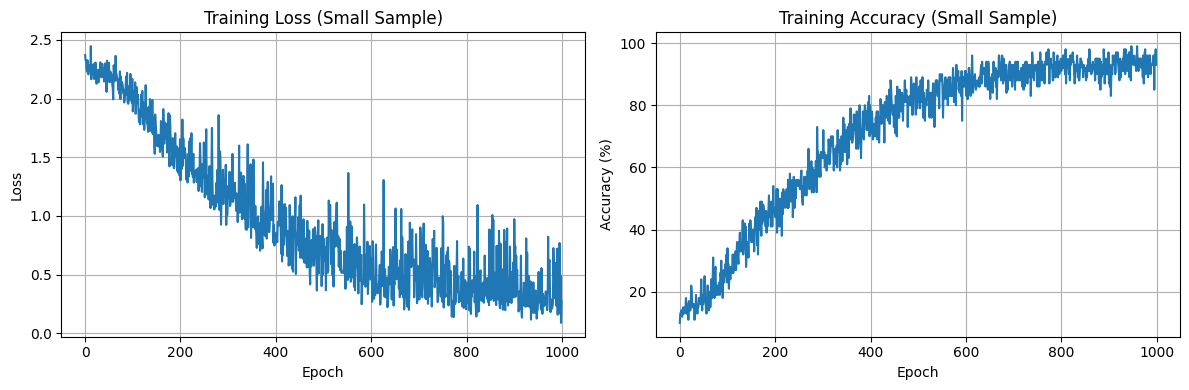


📊 Overfitting Test Results:
   Final Loss: 0.2729
   Final Accuracy: 93.00%
   ⚠️ Model learning but may need more epochs


In [27]:
# Cell 6: Small Sample Overfitting Test
# ========================================
def test_overfitting(model, train_loader_small, test_loader_small, device, epochs=1000):
    """Test if model can overfit to a small sample"""
    print("🔍 Testing RepVGG's ability to overfit small sample...")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader_small, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        avg_loss = epoch_loss / len(train_loader_small)
        accuracy = 100. * correct / total
        
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss (Small Sample)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    ax2.plot(train_accs)
    ax2.set_title('Training Accuracy (Small Sample)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    final_loss = train_losses[-1]
    final_acc = train_accs[-1]
    
    print(f"\n📊 Overfitting Test Results:")
    print(f"   Final Loss: {final_loss:.4f}")
    print(f"   Final Accuracy: {final_acc:.2f}%")
    
    if final_loss < 0.1 and final_acc > 95:
        print("   ✅ RepVGG can overfit successfully!")
    elif final_acc > 80:
        print("   ⚠️ Model learning but may need more epochs")
    else:
        print("   ❌ Model may have issues")
    
    return final_loss, final_acc

# Run overfitting test
print("\nCreating small sample dataset...")
train_loader_small, test_loader_small = get_small_sample_dataloaders(trainset, testset)

model_test = create_RepVGG_A0()
test_loss, test_acc = test_overfitting(model_test, train_loader_small, test_loader_small, device)


In [28]:
# Cell 7: Initialize Wandb and Training Setup
# ========================================
def setup_wandb(project_name="repvgg-cifar10", experiment_name=None, model_variant="A0"):
    """Initialize Weights & Biases logging"""
    
    config = {
        "architecture": f"RepVGG-{model_variant}",
        "dataset": "CIFAR-10",
        "batch_size": 128,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "epochs": 120,
        "optimizer": "SGD",
        "scheduler": "CosineAnnealingLR",
        "warmup_epochs": 5,
        "label_smoothing": 0.1,
        "use_se": False
    }
    
    wandb.init(
        project=project_name,
        name=experiment_name,
        config=config,
        tags=["repvgg", "cifar10", "pytorch", model_variant]
    )
    
    return config

# Initialize wandb (uncomment when ready)
# config = setup_wandb(experiment_name="repvgg_a0_test_run", model_variant="A0")
print("⚠️ Wandb setup ready - uncomment the line above to start logging")

⚠️ Wandb setup ready - uncomment the line above to start logging


In [29]:
def train_repvgg_with_checkpoints(model, trainloader, testloader, device, config, 
                                 log_wandb=False, checkpoint_dir="checkpoints"):
    """Enhanced training function with checkpoint saving"""
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=config.get('label_smoothing', 0.0))
    optimizer = torch.optim.SGD(model.parameters(), 
                               lr=config['learning_rate'], 
                               momentum=config['momentum'], 
                               weight_decay=config['weight_decay'])
    
    # Cosine annealing scheduler with warmup
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    warmup_epochs = config.get('warmup_epochs', 5)
    
    # Training history and best tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'learning_rate': []
    }
    
    best_acc = 0.0
    start_epoch = 0
    
    # Check for existing checkpoint to resume
    latest_checkpoint = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
    if os.path.exists(latest_checkpoint):
        print(f"📂 Found existing checkpoint: {latest_checkpoint}")
        response = input("Resume training from checkpoint? (y/n): ")
        if response.lower() == 'y':
            start_epoch, _, best_acc = load_checkpoint(model, optimizer, scheduler, latest_checkpoint)
            print(f"🔄 Resumed from epoch {start_epoch}, best accuracy: {best_acc:.2f}%")
    
    print(f"🚀 Starting training from epoch {start_epoch+1} for {config['epochs']} total epochs...")
    
    for epoch in range(start_epoch, config['epochs']):
        # Warmup learning rate
        if epoch < warmup_epochs:
            lr_scale = (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = config['learning_rate'] * lr_scale
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{config["epochs"]} [Train]', leave=False)
        
        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            current_lr = optimizer.param_groups[0]['lr']
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%',
                'LR': f'{current_lr:.6f}'
            })
        
        avg_train_loss = train_loss / len(trainloader)
        train_accuracy = 100. * correct / total
        current_lr = optimizer.param_groups[0]['lr']
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        test_pbar = tqdm(testloader, desc=f'Epoch {epoch+1}/{config["epochs"]} [Test]', leave=False)
        
        with torch.no_grad():
            for inputs, targets in test_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                test_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
        
        avg_test_loss = test_loss / len(testloader)
        test_accuracy = 100. * correct / total
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_accuracy)
        history['learning_rate'].append(current_lr)
        
        # Print epoch results
        print(f"Epoch {epoch+1:3d}/{config['epochs']:3d} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:6.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:6.2f}% | "
              f"LR: {current_lr:.6f}")
        
        # Check if best model
        is_best = test_accuracy > best_acc
        if is_best:
            best_acc = test_accuracy
            print(f"🌟 New best accuracy: {best_acc:.2f}%")
        
        # Save checkpoint every 20 epochs or if best model
        if (epoch + 1) % 20 == 0 or is_best or epoch == config['epochs'] - 1:
            checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
            save_checkpoint(model, optimizer, scheduler, epoch + 1, avg_test_loss, 
                          test_accuracy, checkpoint_path, is_best, config)
            print(f"💾 Checkpoint saved: {checkpoint_path}")
        
        # Always save latest checkpoint for resuming
        latest_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
        save_checkpoint(model, optimizer, scheduler, epoch + 1, avg_test_loss, 
                      test_accuracy, latest_path, False, config)
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "test_loss": avg_test_loss,
                "test_accuracy": test_accuracy,
                "learning_rate": current_lr,
                "best_accuracy": best_acc
            })
        
        # Step scheduler (after warmup)
        if epoch >= warmup_epochs:
            scheduler.step()
        
        # Early stopping check (optional)
        if test_accuracy > 95.0:
            print(f"🎉 Reached 95% test accuracy at epoch {epoch+1}!")
            break
    
    print(f"\n🏁 Training completed! Best accuracy: {best_acc:.2f}%")
    return model, history, best_acc

print("✅ Enhanced training function with checkpoints ready!")

✅ Enhanced training function with checkpoints ready!


In [33]:
# Cell 9: Model Evaluation Functions
# ========================================
def evaluate_model_comprehensive(model, testloader, device, model_name="RepVGG"):
    """Comprehensive model evaluation with all metrics"""
    print("\n" + "="*60)
    print(f"🔍 COMPREHENSIVE {model_name} EVALUATION")
    print("="*60)
    
    # 1. Accuracy Metrics
    print("\n1️⃣ Accuracy Metrics:")
    accuracies = calculate_accuracy(model, testloader, device, top_k=(1, 5))
    print(f"   📊 Top-1 Accuracy: {accuracies[1]:.2f}%")
    print(f"   📊 Top-5 Accuracy: {accuracies[5]:.2f}%")
    
    # 2. Computational Complexity
    print("\n2️⃣ Computational Complexity:")
    model_cpu = model.cpu()
    flops = count_flops(model_cpu)
    model = model.to(device)
    print(f"   🧮 FLOPs: {flops:,} ({flops/1e6:.2f} MFLOPs)")
    
    # 3. Inference Performance
    print("\n3️⃣ Inference Performance:")
    avg_latency = measure_inference_time(model, num_runs=100)
    throughput = 1000 / avg_latency
    print(f"   ⚡ Average Inference Time: {avg_latency:.2f} ms")
    print(f"   🚀 Throughput: {throughput:.2f} images/second")
    
    # 4. Model Statistics
    print("\n4️⃣ Model Statistics:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = total_params * 4 / 1024 / 1024
    
    print(f"   📈 Total Parameters: {total_params:,}")
    print(f"   🎯 Trainable Parameters: {trainable_params:,}")
    print(f"   💾 Model Size: {model_size_mb:.2f} MB (float32)")
    
    # 5. Efficiency Metrics
    print("\n5️⃣ Efficiency Metrics:")
    flops_per_param = flops / total_params
    accuracy_per_flop = accuracies[1] / (flops / 1e6)
    
    print(f"   ⚖️ FLOPs per Parameter: {flops_per_param:.2f}")
    print(f"   🎯 Accuracy per MFLOP: {accuracy_per_flop:.2f}")
    
    eval_results = {
        'model_name': model_name,
        'top1_accuracy': accuracies[1],
        'top5_accuracy': accuracies[5],
        'flops': flops,
        'flops_mflops': flops / 1e6,
        'inference_time_ms': avg_latency,
        'throughput_imgs_sec': throughput,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'model_size_mb': model_size_mb,
        'flops_per_param': flops_per_param,
        'accuracy_per_mflop': accuracy_per_flop
    }
    
    return eval_results

def plot_training_history(history, model_name="RepVGG"):
    """Plot training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    ax1.set_title(f'{model_name} Training and Test Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
    ax2.set_title(f'{model_name} Training and Test Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning rate plot
    ax3.plot(epochs, history['learning_rate'], 'g-', label='Learning Rate', linewidth=2)
    ax3.set_title(f'{model_name} Learning Rate Schedule', fontsize=14)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Combined accuracy with fill
    ax4.plot(epochs, history['train_acc'], 'b-', alpha=0.7, label='Train Accuracy')
    ax4.plot(epochs, history['test_acc'], 'r-', alpha=0.7, label='Test Accuracy')
    ax4.fill_between(epochs, history['train_acc'], alpha=0.3, color='blue')
    ax4.fill_between(epochs, history['test_acc'], alpha=0.3, color='red')
    ax4.set_title(f'{model_name} Accuracy Comparison', fontsize=14)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def save_model_and_results(model, history, eval_results, best_acc, filepath='repvgg_cifar10_final.pth'):
    """Save final model and all results"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_history': history,
        'evaluation_results': eval_results,
        'best_accuracy': best_acc,
        'model_config': {
            'architecture': eval_results['model_name'],
            'num_classes': 10,
        }
    }, filepath)
    print(f"💾 Final model and results saved to: {filepath}")

def compare_repvgg_variants():
    """Compare different RepVGG variants"""
    print("🔬 REPVGG VARIANTS COMPARISON")
    print("="*60)
    
    variants = {
        'RepVGG-A0': create_RepVGG_A0(),
        'RepVGG-A1': create_RepVGG_A1(),
        'RepVGG-A2': create_RepVGG_A2(),
        'RepVGG-B0': create_RepVGG_B0(),
    }
    
    comparison_data = []
    
    for name, model in variants.items():
        model.eval()
        
        # Calculate metrics
        total_params = sum(p.numel() for p in model.parameters())
        flops = count_flops(model)
        avg_latency = measure_inference_time(model, num_runs=50)
        
        comparison_data.append({
            'Model': name,
            'Parameters (M)': total_params / 1e6,
            'FLOPs (M)': flops / 1e6,
            'Latency (ms)': avg_latency,
            'Throughput (img/s)': 1000 / avg_latency
        })
    
    # Print comparison table
    print(f"{'Model':<12} {'Params(M)':<10} {'FLOPs(M)':<10} {'Latency(ms)':<12} {'Throughput':<12}")
    print("-" * 60)
    for data in comparison_data:
        print(f"{data['Model']:<12} {data['Parameters (M)']:<10.2f} {data['FLOPs (M)']:<10.1f} "
              f"{data['Latency (ms)']:<12.2f} {data['Throughput']:<12.1f}")
    
    return comparison_data

print("✅ Evaluation functions ready!")

✅ Evaluation functions ready!


In [34]:
# Cell 10: Quick Training Test
# ========================================
def quick_training_test(epochs=5, model_variant="A0"):
    """Quick training test with few epochs"""
    print(f"🧪 Running quick RepVGG-{model_variant} training test ({epochs} epochs)...")
    
    # Create model based on variant
    model_creators = {
        "A0": create_RepVGG_A0,
        "A1": create_RepVGG_A1,
        "A2": create_RepVGG_A2,
        "B0": create_RepVGG_B0
    }
    
    model = model_creators[model_variant]()
    
    # Quick config
    quick_config = {
        "epochs": epochs,
        "learning_rate": 0.01,
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "warmup_epochs": 2,
        "label_smoothing": 0.0
    }
    
    # Use smaller dataloaders
    train_subset_indices = torch.randperm(len(trainset))[:1000]
    test_subset_indices = torch.randperm(len(testset))[:200]
    
    train_subset = Subset(trainset, train_subset_indices)
    test_subset = Subset(testset, test_subset_indices)
    
    quick_trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    quick_testloader = DataLoader(test_subset, batch_size=64, shuffle=False)
    
    print(f"   Using {len(train_subset)} training samples and {len(test_subset)} test samples")
    
    # Train
    trained_model, history, best_acc = train_repvgg_with_checkpoints(
        model, quick_trainloader, quick_testloader, device, quick_config, 
        log_wandb=False, checkpoint_dir="checkpoints/quick_test"
    )
    
    # Quick evaluation
    print(f"\n📊 Quick Test Results:")
    print(f"   Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"   Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
    print(f"   Best Accuracy: {best_acc:.2f}%")
    
    # Plot results
    plot_training_history(history, f"RepVGG-{model_variant} (Quick Test)")
    
    return trained_model, history

# Run quick test
print("Running quick training test...")
os.makedirs("checkpoints/quick_test", exist_ok=True)
quick_model, quick_history = quick_training_test(epochs=5, model_variant="A0")


Running quick training test...
🧪 Running quick RepVGG-A0 training test (5 epochs)...
   Using 1000 training samples and 200 test samples
📂 Found existing checkpoint: checkpoints/quick_test/latest_checkpoint.pth


Resume training from checkpoint? (y/n):  y


🔄 Resumed from epoch 5, best accuracy: 9.50%
🚀 Starting training from epoch 6 for 5 total epochs...

🏁 Training completed! Best accuracy: 9.50%

📊 Quick Test Results:


IndexError: list index out of range

In [40]:
def run_full_training(model_variant="A0", use_wandb=True):
    """Run the complete training pipeline"""
    
    print(f"🚀 Starting Full RepVGG-{model_variant} Training Pipeline...")
    print("="*60)
    
    # Create model
    model_creators = {
        "A0": create_RepVGG_A0,
        "A1": create_RepVGG_A1,
        "A2": create_RepVGG_A2,
        "B0": create_RepVGG_B0
    }
    
    model = model_creators[model_variant]()
    
    # Full training config
    full_config = {
        "architecture": f"RepVGG-{model_variant}",
        "dataset": "CIFAR-10",
        "batch_size": 128,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "epochs": 50,
        "optimizer": "SGD",
        "scheduler": "CosineAnnealingLR",
        "warmup_epochs": 5,
        "label_smoothing": 0.1,
        "use_se": False
    }
    
    print("Configuration:")
    for key, value in full_config.items():
        print(f"   {key}: {value}")
    
    # Setup wandb if requested
    if use_wandb:
        wandb.init(
            project="repvgg-cifar10", 
            name=f"repvgg_{model_variant.lower()}_full_training",
            config=full_config,
            tags=["repvgg", "cifar10", "full_training", model_variant]
        )
        print("✅ Wandb logging enabled")
    else:
        print("⚠️ Wandb logging disabled")
    
    print(f"\n🎯 Training will take approximately 2-3 hours depending on your hardware.")
    print(f"💾 Checkpoints will be saved every 20 epochs in checkpoints/full_training/")
    
    # Ask for confirmation
    response = input("Continue with full training? (y/n): ")
    if response.lower() != 'y':
        print("Training cancelled.")
        return None, None, None, None
    
    # Create checkpoint directory
    checkpoint_dir = f"checkpoints/full_training_{model_variant}"
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Start training
    print("\n" + "="*60)
    print(f"🏃‍♂️ STARTING FULL RepVGG-{model_variant} TRAINING")
    print("="*60)
    
    trained_model, history, best_acc = train_repvgg_with_checkpoints(
        model, trainloader, testloader, device, full_config, 
        log_wandb=use_wandb, checkpoint_dir=checkpoint_dir
    )
    
    print(f"\n🎉 Training completed! Best accuracy: {best_acc:.2f}%")
    
    # Comprehensive evaluation
    eval_results = evaluate_model_comprehensive(trained_model, testloader, device, f"RepVGG-{model_variant}")
    
    # Plot training history
    plot_training_history(history, f"RepVGG-{model_variant}")
    
    # Log final results to wandb
    if use_wandb and wandb.run is not None:
        wandb.log(eval_results)
        wandb.finish()
    
    # Save everything
    final_save_path = f'repvgg_{model_variant.lower()}_cifar10_final.pth'
    save_model_and_results(trained_model, history, eval_results, best_acc, final_save_path)
    
    return trained_model, history, eval_results, best_acc

print("✅ Full training pipeline ready!")
print("💡 Run the cell below to start full training, or continue with demo evaluation.")


✅ Full training pipeline ready!
💡 Run the cell below to start full training, or continue with demo evaluation.


🚀 Starting Full RepVGG-A0 Training Pipeline...
Configuration:
   architecture: RepVGG-A0
   dataset: CIFAR-10
   batch_size: 128
   learning_rate: 0.1
   momentum: 0.9
   weight_decay: 0.0001
   epochs: 50
   optimizer: SGD
   scheduler: CosineAnnealingLR
   warmup_epochs: 5
   label_smoothing: 0.1
   use_se: False


✅ Wandb logging enabled

🎯 Training will take approximately 2-3 hours depending on your hardware.
💾 Checkpoints will be saved every 20 epochs in checkpoints/full_training/


Continue with full training? (y/n):  y



🏃‍♂️ STARTING FULL RepVGG-A0 TRAINING
📂 Found existing checkpoint: checkpoints/full_training_A0/latest_checkpoint.pth


Resume training from checkpoint? (y/n):  y


🔄 Resumed from epoch 1, best accuracy: 31.52%
🚀 Starting training from epoch 2 for 50 total epochs...


Epoch 2/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   2/ 50 | Train Loss: 1.9022 | Train Acc:  32.80% | Test Loss: 1.8060 | Test Acc:  38.47% | LR: 0.040000
🌟 New best accuracy: 38.47%
💫 New best model saved: best_models/full_training_A0/epoch_2_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_2.pth


Epoch 3/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   3/ 50 | Train Loss: 1.7282 | Train Acc:  42.48% | Test Loss: 1.5755 | Test Acc:  49.41% | LR: 0.060000
🌟 New best accuracy: 49.41%
💫 New best model saved: best_models/full_training_A0/epoch_3_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_3.pth


Epoch 4/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   4/ 50 | Train Loss: 1.5795 | Train Acc:  50.43% | Test Loss: 1.4456 | Test Acc:  57.34% | LR: 0.080000
🌟 New best accuracy: 57.34%
💫 New best model saved: best_models/full_training_A0/epoch_4_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_4.pth


Epoch 5/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   5/ 50 | Train Loss: 1.4510 | Train Acc:  57.04% | Test Loss: 1.3235 | Test Acc:  63.31% | LR: 0.100000
🌟 New best accuracy: 63.31%
💫 New best model saved: best_models/full_training_A0/epoch_5_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_5.pth


Epoch 6/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   6/ 50 | Train Loss: 1.3308 | Train Acc:  62.80% | Test Loss: 1.2483 | Test Acc:  66.67% | LR: 0.100000
🌟 New best accuracy: 66.67%
💫 New best model saved: best_models/full_training_A0/epoch_6_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_6.pth


Epoch 7/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   7/ 50 | Train Loss: 1.2457 | Train Acc:  66.76% | Test Loss: 1.1946 | Test Acc:  69.42% | LR: 0.099983
🌟 New best accuracy: 69.42%
💫 New best model saved: best_models/full_training_A0/epoch_7_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_7.pth


Epoch 8/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   8/ 50 | Train Loss: 1.1834 | Train Acc:  69.69% | Test Loss: 1.1197 | Test Acc:  72.96% | LR: 0.099931
🌟 New best accuracy: 72.96%
💫 New best model saved: best_models/full_training_A0/epoch_8_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_8.pth


Epoch 9/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   9/ 50 | Train Loss: 1.1455 | Train Acc:  71.47% | Test Loss: 1.0333 | Test Acc:  76.73% | LR: 0.099846
🌟 New best accuracy: 76.73%
💫 New best model saved: best_models/full_training_A0/epoch_9_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_9.pth


Epoch 10/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  10/ 50 | Train Loss: 1.1094 | Train Acc:  72.92% | Test Loss: 1.0274 | Test Acc:  76.21% | LR: 0.099726


Epoch 11/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  11/ 50 | Train Loss: 1.0847 | Train Acc:  74.16% | Test Loss: 1.0003 | Test Acc:  77.92% | LR: 0.099572
🌟 New best accuracy: 77.92%
💫 New best model saved: best_models/full_training_A0/epoch_11_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_11.pth


Epoch 12/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  12/ 50 | Train Loss: 1.0626 | Train Acc:  74.90% | Test Loss: 1.0036 | Test Acc:  78.22% | LR: 0.099384
🌟 New best accuracy: 78.22%
💫 New best model saved: best_models/full_training_A0/epoch_12_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_12.pth


Epoch 13/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  13/ 50 | Train Loss: 1.0344 | Train Acc:  76.41% | Test Loss: 1.0195 | Test Acc:  77.24% | LR: 0.099163


Epoch 14/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  14/ 50 | Train Loss: 1.0199 | Train Acc:  76.93% | Test Loss: 1.0120 | Test Acc:  77.60% | LR: 0.098907


Epoch 15/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  15/ 50 | Train Loss: 1.0075 | Train Acc:  77.61% | Test Loss: 0.9809 | Test Acc:  79.40% | LR: 0.098618
🌟 New best accuracy: 79.40%
💫 New best model saved: best_models/full_training_A0/epoch_15_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_15.pth


Epoch 16/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  16/ 50 | Train Loss: 0.9918 | Train Acc:  78.27% | Test Loss: 0.9122 | Test Acc:  81.96% | LR: 0.098296
🌟 New best accuracy: 81.96%
💫 New best model saved: best_models/full_training_A0/epoch_16_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_16.pth


Epoch 17/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  17/ 50 | Train Loss: 0.9842 | Train Acc:  78.60% | Test Loss: 0.9174 | Test Acc:  82.15% | LR: 0.097941
🌟 New best accuracy: 82.15%
💫 New best model saved: best_models/full_training_A0/epoch_17_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_17.pth


Epoch 18/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  18/ 50 | Train Loss: 0.9678 | Train Acc:  79.35% | Test Loss: 0.9447 | Test Acc:  80.36% | LR: 0.097553


Epoch 19/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  19/ 50 | Train Loss: 0.9559 | Train Acc:  79.80% | Test Loss: 0.8991 | Test Acc:  82.70% | LR: 0.097132
🌟 New best accuracy: 82.70%
💫 New best model saved: best_models/full_training_A0/epoch_19_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_19.pth


Epoch 20/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  20/ 50 | Train Loss: 0.9520 | Train Acc:  80.01% | Test Loss: 0.8732 | Test Acc:  83.50% | LR: 0.096679
🌟 New best accuracy: 83.50%
💫 New best model saved: best_models/full_training_A0/epoch_20_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_20.pth


Epoch 21/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  21/ 50 | Train Loss: 0.9408 | Train Acc:  80.70% | Test Loss: 0.9222 | Test Acc:  81.17% | LR: 0.096194


Epoch 22/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  22/ 50 | Train Loss: 0.9337 | Train Acc:  81.00% | Test Loss: 0.8977 | Test Acc:  82.87% | LR: 0.095677


Epoch 23/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  23/ 50 | Train Loss: 0.9289 | Train Acc:  81.04% | Test Loss: 0.8890 | Test Acc:  83.20% | LR: 0.095129


Epoch 24/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  24/ 50 | Train Loss: 0.9168 | Train Acc:  81.56% | Test Loss: 0.9053 | Test Acc:  82.29% | LR: 0.094550


Epoch 25/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  25/ 50 | Train Loss: 0.9136 | Train Acc:  81.66% | Test Loss: 0.8590 | Test Acc:  84.17% | LR: 0.093941
🌟 New best accuracy: 84.17%
💫 New best model saved: best_models/full_training_A0/epoch_25_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_25.pth


Epoch 26/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  26/ 50 | Train Loss: 0.9042 | Train Acc:  82.23% | Test Loss: 0.9619 | Test Acc:  80.66% | LR: 0.093301


Epoch 27/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  27/ 50 | Train Loss: 0.9083 | Train Acc:  81.98% | Test Loss: 0.9090 | Test Acc:  81.81% | LR: 0.092632


Epoch 28/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  28/ 50 | Train Loss: 0.8915 | Train Acc:  82.68% | Test Loss: 0.8532 | Test Acc:  84.56% | LR: 0.091934
🌟 New best accuracy: 84.56%
💫 New best model saved: best_models/full_training_A0/epoch_28_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_28.pth


Epoch 29/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  29/ 50 | Train Loss: 0.8939 | Train Acc:  82.76% | Test Loss: 0.8798 | Test Acc:  83.40% | LR: 0.091206


Epoch 30/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  30/ 50 | Train Loss: 0.8854 | Train Acc:  83.03% | Test Loss: 0.8500 | Test Acc:  84.62% | LR: 0.090451
🌟 New best accuracy: 84.62%
💫 New best model saved: best_models/full_training_A0/epoch_30_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_30.pth


Epoch 31/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  31/ 50 | Train Loss: 0.8776 | Train Acc:  83.35% | Test Loss: 0.8674 | Test Acc:  83.95% | LR: 0.089668


Epoch 32/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  32/ 50 | Train Loss: 0.8752 | Train Acc:  83.40% | Test Loss: 0.8331 | Test Acc:  85.49% | LR: 0.088857
🌟 New best accuracy: 85.49%
💫 New best model saved: best_models/full_training_A0/epoch_32_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_32.pth


Epoch 33/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  33/ 50 | Train Loss: 0.8681 | Train Acc:  83.80% | Test Loss: 0.8419 | Test Acc:  85.19% | LR: 0.088020


Epoch 34/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  34/ 50 | Train Loss: 0.8686 | Train Acc:  83.82% | Test Loss: 0.8226 | Test Acc:  85.91% | LR: 0.087157
🌟 New best accuracy: 85.91%
💫 New best model saved: best_models/full_training_A0/epoch_34_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_34.pth


Epoch 35/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  35/ 50 | Train Loss: 0.8621 | Train Acc:  84.23% | Test Loss: 0.8592 | Test Acc:  84.26% | LR: 0.086269


Epoch 36/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  36/ 50 | Train Loss: 0.8547 | Train Acc:  84.35% | Test Loss: 0.8447 | Test Acc:  84.55% | LR: 0.085355


Epoch 37/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  37/ 50 | Train Loss: 0.8540 | Train Acc:  84.56% | Test Loss: 0.8683 | Test Acc:  84.09% | LR: 0.084418


Epoch 38/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  38/ 50 | Train Loss: 0.8481 | Train Acc:  84.64% | Test Loss: 0.8262 | Test Acc:  85.69% | LR: 0.083457


Epoch 39/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  39/ 50 | Train Loss: 0.8447 | Train Acc:  84.75% | Test Loss: 0.8611 | Test Acc:  84.76% | LR: 0.082472


Epoch 40/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  40/ 50 | Train Loss: 0.8393 | Train Acc:  85.07% | Test Loss: 0.8277 | Test Acc:  85.67% | LR: 0.081466
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_40.pth


Epoch 41/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  41/ 50 | Train Loss: 0.8361 | Train Acc:  85.22% | Test Loss: 0.8172 | Test Acc:  86.08% | LR: 0.080438
🌟 New best accuracy: 86.08%
💫 New best model saved: best_models/full_training_A0/epoch_41_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_41.pth


Epoch 42/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  42/ 50 | Train Loss: 0.8283 | Train Acc:  85.51% | Test Loss: 0.8069 | Test Acc:  86.82% | LR: 0.079389
🌟 New best accuracy: 86.82%
💫 New best model saved: best_models/full_training_A0/epoch_42_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_42.pth


Epoch 43/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  43/ 50 | Train Loss: 0.8289 | Train Acc:  85.53% | Test Loss: 0.8769 | Test Acc:  84.44% | LR: 0.078320


Epoch 44/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  44/ 50 | Train Loss: 0.8260 | Train Acc:  85.68% | Test Loss: 0.8019 | Test Acc:  86.88% | LR: 0.077232
🌟 New best accuracy: 86.88%
💫 New best model saved: best_models/full_training_A0/epoch_44_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_44.pth


Epoch 45/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  45/ 50 | Train Loss: 0.8218 | Train Acc:  85.79% | Test Loss: 0.8057 | Test Acc:  86.72% | LR: 0.076125


Epoch 46/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  46/ 50 | Train Loss: 0.8187 | Train Acc:  85.91% | Test Loss: 0.8081 | Test Acc:  86.46% | LR: 0.075000


Epoch 47/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  47/ 50 | Train Loss: 0.8133 | Train Acc:  86.31% | Test Loss: 0.8116 | Test Acc:  86.52% | LR: 0.073858


Epoch 48/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  48/ 50 | Train Loss: 0.8103 | Train Acc:  86.31% | Test Loss: 0.8106 | Test Acc:  86.91% | LR: 0.072700
🌟 New best accuracy: 86.91%
💫 New best model saved: best_models/full_training_A0/epoch_48_best.pth
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_48.pth


Epoch 49/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  49/ 50 | Train Loss: 0.8051 | Train Acc:  86.57% | Test Loss: 0.8093 | Test Acc:  86.59% | LR: 0.071526


Epoch 50/50 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  50/ 50 | Train Loss: 0.8017 | Train Acc:  86.67% | Test Loss: 0.8106 | Test Acc:  86.40% | LR: 0.070337
💾 Checkpoint saved: checkpoints/full_training_A0/epoch_50.pth

🏁 Training completed! Best accuracy: 86.91%

🎉 Training completed! Best accuracy: 86.91%

🔍 COMPREHENSIVE RepVGG-A0 EVALUATION

1️⃣ Accuracy Metrics:


Calculating accuracy:   0%|          | 0/79 [00:00<?, ?it/s]

   📊 Top-1 Accuracy: 86.40%
   📊 Top-5 Accuracy: 99.28%

2️⃣ Computational Complexity:
   🧮 FLOPs: 123,384,320 (123.38 MFLOPs)

3️⃣ Inference Performance:
   ⚡ Average Inference Time: 3.11 ms
   🚀 Throughput: 321.61 images/second

4️⃣ Model Statistics:
   📈 Total Parameters: 7,840,778
   🎯 Trainable Parameters: 7,840,778
   💾 Model Size: 29.91 MB (float32)

5️⃣ Efficiency Metrics:
   ⚖️ FLOPs per Parameter: 15.74
   🎯 Accuracy per MFLOP: 0.70


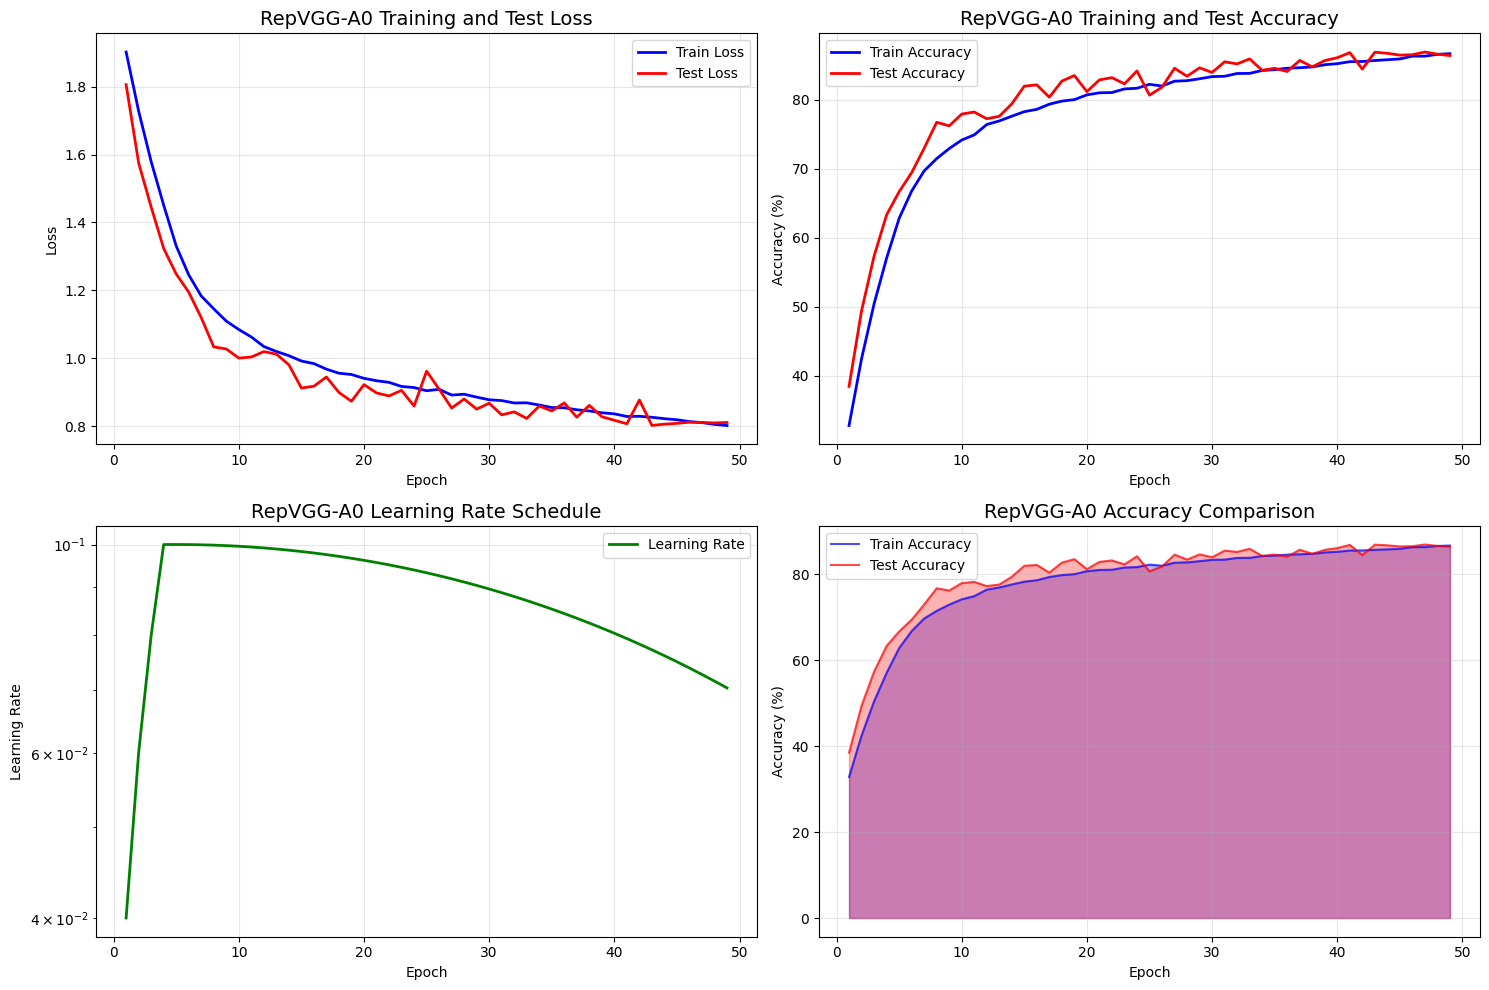

accuracy_per_mflop,▁
best_accuracy,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇█████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
flops,▁
flops_mflops,▁
flops_per_param,▁
inference_time_ms,▁
learning_rate,▁▃▆█████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅
model_size_mb,▁
test_accuracy,▁▃▄▅▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████████████████
+8,...


💾 Final model and results saved to: repvgg_a0_cifar10_final.pth


In [41]:
trained_model, history, eval_results, best_acc = run_full_training()

## MobileViT

In [44]:
# Cell 1: Setup and Imports
# ========================================
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import timm  # PyTorch Image Models - có sẵn MobileViT
import time
import numpy as np
from tqdm.notebook import tqdm
import wandb
import matplotlib.pyplot as plt
import os
import shutil

# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('best_models', exist_ok=True)

print(f"✅ Using device: {device}")
print("📦 Using timm library for pre-built MobileViT models")

✅ Using device: cuda
📦 Using timm library for pre-built MobileViT models


In [54]:
# Cell 2: Model Creation and Finetuning Setup
# ========================================
def create_mobilevit_model(variant='mobilevit_xxs', num_classes=10, pretrained=True):
    """Create MobileViT model using timm library with ImageNet pretrained weights"""
    try:
        model = timm.create_model(variant, pretrained=pretrained, num_classes=num_classes)
        print(f"✅ Created {variant} (pretrained={pretrained}) with {sum(p.numel() for p in model.parameters()):,} parameters")
        return model, variant
    except:
        print(f"⚠️ {variant} not available, trying alternatives...")
        # Try alternative models
        alternatives = ['mobilenetv3_small_100', 'efficientnet_b0', 'resnet18']
        for alt in alternatives:
            try:
                model = timm.create_model(alt, pretrained=pretrained, num_classes=num_classes)
                print(f"✅ Using {alt} as fallback (pretrained={pretrained})")
                return model, alt
            except:
                continue
        
        # Last resort
        model = timm.create_model('resnet18', pretrained=False, num_classes=num_classes)
        print(f"✅ Using ResNet18 without pretrain as last resort")
        return model, 'resnet18'

def setup_finetuning(model, model_name, freeze_backbone=False):
    """Setup model for finetuning"""
    if freeze_backbone and 'mobilevit' in model_name.lower():
        print("🔒 Freezing backbone for feature extractor training...")
        # Freeze all layers except classifier
        for name, param in model.named_parameters():
            if 'classifier' not in name and 'head' not in name:
                param.requires_grad = False
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"📊 Model setup:")
    print(f"   Total params: {total_params:,}")
    print(f"   Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
    
    return model

def test_model_shapes():
    """Quick shape test with finetuning setup"""
    print("🧪 Testing model shapes and finetuning setup...")
    
    models_to_test = [
        'mobilevit_xxs',
        'mobilevit_xs', 
        'mobilevit_s',
        'mobilenetv3_small_100',
        'efficientnet_b0'
    ]
    
    for variant in models_to_test:
        try:
            model, actual_variant = create_mobilevit_model(variant, pretrained=True)
            model = setup_finetuning(model, actual_variant, freeze_backbone=False)
            model.eval()
            
            x = torch.randn(4, 3, 32, 32)
            with torch.no_grad():
                out = model(x)
            print(f"   {actual_variant}: {tuple(x.shape)} → {tuple(out.shape)} ✅")
            return model, actual_variant
        except Exception as e:
            print(f"   {variant}: ❌ {str(e)[:50]}")
            continue
    
    # Fallback
    model, variant = create_mobilevit_model('resnet18', pretrained=True)
    return model, variant

# Test and get working model
model, model_name = test_model_shapes()
print(f"🎯 Selected model: {model_name} for finetuning on CIFAR-10")

🧪 Testing model shapes and finetuning setup...


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

✅ Created mobilevit_xxs (pretrained=True) with 954,234 parameters
📊 Model setup:
   Total params: 954,234
   Trainable params: 954,234 (100.0%)
   mobilevit_xxs: (4, 3, 32, 32) → (4, 10) ✅
🎯 Selected model: mobilevit_xxs for finetuning on CIFAR-10


In [47]:
# Cell 3: Data Loading
# ========================================
def get_cifar10_loaders(batch_size=128):
    """Get CIFAR-10 data loaders with strong augmentation"""
    
    transform_train = transforms.Compose([
        transforms.Resize(36),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        transforms.RandomErasing(p=0.25)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return trainloader, testloader, trainset, testset

trainloader, testloader, trainset, testset = get_cifar10_loaders()
print(f"✅ Data loaded: {len(trainset)} train, {len(testset)} test samples")


✅ Data loaded: 50000 train, 10000 test samples


In [48]:
# Cell 4: Utility Functions
# ========================================
def count_flops_simple(model, input_size=(4, 3, 32, 32)):
    """Simple FLOPs counting"""
    try:
        from fvcore.nn import FlopCountMode, flop_count
        model.eval()
        x = torch.randn(input_size)
        flops = flop_count(model, (x,), supported_ops=None)[0]
        return flops
    except:
        # Fallback estimation
        params = sum(p.numel() for p in model.parameters())
        return params * 2  # Rough estimation

def measure_inference_time(model, input_size=(4, 3, 32, 32), runs=100):
    """Measure inference time"""
    model.eval()
    model = model.to(device)
    x = torch.randn(input_size).to(device)
    
    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(x)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start = time.time()
    for _ in range(runs):
        with torch.no_grad():
            _ = model(x)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    return (time.time() - start) * 1000 / runs  # ms

def calculate_accuracy(model, dataloader, device):
    """Calculate accuracy"""
    model.eval()
    correct = total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return 100. * correct / total

def save_checkpoint(model, optimizer, epoch, acc, path, is_best=False):
    """Save checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': acc
    }, path)
    
    if is_best:
        best_path = path.replace('.pth', '_best.pth')
        shutil.copy(path, best_path)
        print(f"💫 Best model saved: {best_path}")

print("✅ Utility functions ready")

✅ Utility functions ready


In [55]:
# Cell 5: Enhanced Training Function for Finetuning
# ========================================
def train_model(model, model_name, trainloader, testloader, device, epochs=100, lr=0.001, 
                save_freq=20, freeze_epochs=0):
    """Enhanced training function for finetuning pretrained models"""
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Different learning rates for finetuning
    if freeze_epochs > 0:
        # Two-stage training: frozen backbone + full training
        print(f"📚 Two-stage training: {freeze_epochs} epochs frozen + {epochs-freeze_epochs} epochs full")
    
    # Optimizer setup for finetuning (lower LR for pretrained weights)
    if 'resnet' in model_name.lower() and freeze_epochs == 0:
        # Different LRs for backbone vs classifier
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if 'fc' in name or 'classifier' in name or 'head' in name:
                classifier_params.append(param)
            else:
                backbone_params.append(param)
        
        optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': lr * 0.1},  # Lower LR for pretrained backbone
            {'params': classifier_params, 'lr': lr}       # Higher LR for new classifier
        ], weight_decay=0.01)
        print(f"📖 Using different LRs: backbone={lr*0.1:.1e}, classifier={lr:.1e}")
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        print(f"📖 Using single LR: {lr:.1e}")
    
    # Scheduler for finetuning
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr*0.01)
    
    history = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'lr': []}
    best_acc = 0
    
    print(f"🚀 Finetuning {model_name} for {epochs} epochs on CIFAR-10...")
    print(f"💾 Checkpoints will be saved every {save_freq} epochs")
    
    for epoch in range(epochs):
        # Handle frozen training
        if epoch == freeze_epochs and freeze_epochs > 0:
            print(f"🔓 Unfreezing backbone at epoch {epoch+1}")
            for param in model.parameters():
                param.requires_grad = True
            # Reset optimizer for full training
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr*0.1, weight_decay=0.01)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-freeze_epochs, eta_min=lr*0.001)
        
        # Training phase
        model.train()
        train_loss = correct = total = 0
        
        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'Loss': f'{loss.item():.3f}', 
                'Acc': f'{100.*correct/total:.1f}%',
                'LR': f'{current_lr:.1e}'
            })
        
        train_acc = 100. * correct / total
        avg_train_loss = train_loss / len(trainloader)
        
        # Validation phase
        test_acc = calculate_accuracy(model, testloader, device)
        
        # Update history
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(0)  # Simplified
        history['lr'].append(current_lr)
        
        # Save checkpoint
        is_best = test_acc > best_acc
        if is_best:
            best_acc = test_acc
        
        if (epoch + 1) % save_freq == 0 or is_best or epoch == epochs - 1:
            checkpoint_path = f'checkpoints/{model_name}_epoch_{epoch+1}.pth'
            save_checkpoint(model, optimizer, epoch + 1, test_acc, checkpoint_path, is_best)
            if (epoch + 1) % save_freq == 0:
                print(f"💾 Saved checkpoint: {checkpoint_path}")
        
        scheduler.step()
        
        # Print progress
        status = "🌟" if is_best else ""
        print(f"Epoch {epoch+1:3d}/{epochs}: Train {train_acc:5.1f}% | "
              f"Test {test_acc:5.1f}% | LR {current_lr:.1e} {status}")
        
        # Early stopping
        if test_acc > 96:
            print("🎉 Reached 96% accuracy - early stopping!")
            break
    
    print(f"✅ Finetuning complete! Best accuracy: {best_acc:.2f}%")
    return model, history, best_acc

print("✅ Training function ready")

✅ Training function ready


In [56]:
# Cell 6: Quick Finetuning Test (5 epochs)
# ========================================
def quick_test():
    """Quick 5-epoch finetuning test"""
    print("🧪 Running quick finetuning test (5 epochs on 1000 samples)...")
    
    # Small subset for quick test
    indices = torch.randperm(len(trainset))[:1000]
    small_trainset = Subset(trainset, indices)
    small_trainloader = DataLoader(small_trainset, batch_size=64, shuffle=True)
    
    indices = torch.randperm(len(testset))[:200]
    small_testset = Subset(testset, indices)
    small_testloader = DataLoader(small_testset, batch_size=64, shuffle=False)
    
    # Create fresh pretrained model for finetuning
    quick_model, quick_model_name = create_mobilevit_model('mobilenetv3_small_100', pretrained=True)
    quick_model = setup_finetuning(quick_model, quick_model_name, freeze_backbone=False)
    
    print(f"📚 Finetuning {quick_model_name} (pretrained=True) on small CIFAR-10 subset...")
    
    # Train with finetuning-specific settings
    quick_model, history, best_acc = train_model(
        quick_model, quick_model_name, small_trainloader, small_testloader, device, 
        epochs=5, lr=0.001, save_freq=5, freeze_epochs=0  # No freezing for quick test
    )
    
    print(f"🎯 Quick finetuning results:")
    print(f"   Final accuracy: {history['test_acc'][-1]:.2f}%")
    print(f"   Best accuracy: {best_acc:.2f}%")
    print(f"   Improvement: {history['test_acc'][-1] - history['test_acc'][0]:.2f}% points")
    
    return quick_model, history

# Run quick test
quick_model, quick_history = quick_test()

🧪 Running quick finetuning test (5 epochs on 1000 samples)...


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

✅ Created mobilenetv3_small_100 (pretrained=True) with 1,528,106 parameters
📊 Model setup:
   Total params: 1,528,106
   Trainable params: 1,528,106 (100.0%)
📚 Finetuning mobilenetv3_small_100 (pretrained=True) on small CIFAR-10 subset...
📖 Using single LR: 1.0e-03
🚀 Finetuning mobilenetv3_small_100 for 5 epochs on CIFAR-10...
💾 Checkpoints will be saved every 5 epochs


Epoch 1/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilenetv3_small_100_epoch_1_best.pth
Epoch   1/5: Train  12.5% | Test  12.5% | LR 1.0e-03 🌟


Epoch 2/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   2/5: Train  13.8% | Test  10.5% | LR 9.1e-04 


Epoch 3/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilenetv3_small_100_epoch_3_best.pth
Epoch   3/5: Train  14.7% | Test  13.0% | LR 6.6e-04 🌟


Epoch 4/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilenetv3_small_100_epoch_4_best.pth
Epoch   4/5: Train  16.5% | Test  18.0% | LR 3.5e-04 🌟


Epoch 5/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilenetv3_small_100_epoch_5_best.pth
💾 Saved checkpoint: checkpoints/mobilenetv3_small_100_epoch_5.pth
Epoch   5/5: Train  16.6% | Test  19.0% | LR 1.0e-04 🌟
✅ Finetuning complete! Best accuracy: 19.00%
🎯 Quick finetuning results:
   Final accuracy: 19.00%
   Best accuracy: 19.00%
   Improvement: 6.50% points



📊 Evaluating Quick Test Model...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Results for Quick Test Model:
  📊 Accuracy: 19.49%
  📈 Parameters: 1,528,106 (1.5M)
  🧮 FLOPs: 3,056,212 (3.1M)
  ⚡ Inference: 2.47ms
  🚀 Throughput: 404.4 FPS
  💾 Size: 5.8MB


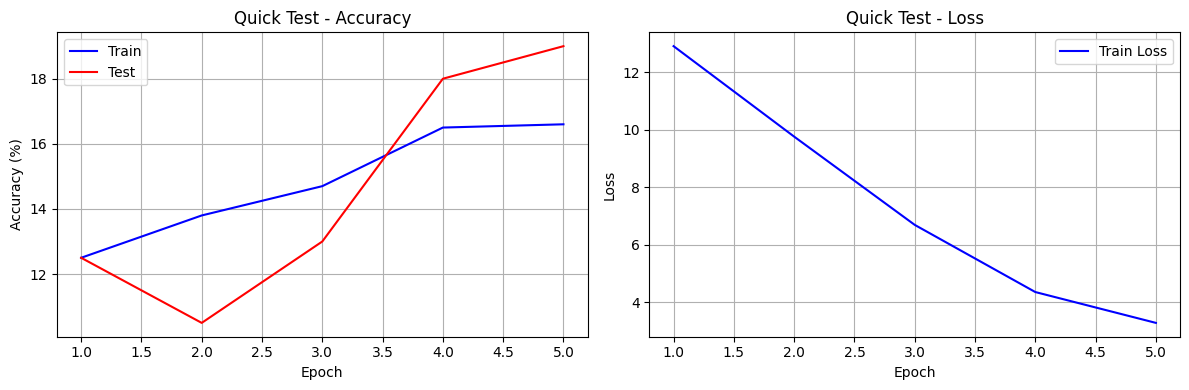

In [57]:
# Cell 7: Evaluation and Visualization
# ========================================
def evaluate_comprehensive(model, testloader, device, model_name="MobileViT"):
    """Comprehensive evaluation"""
    print(f"\n📊 Evaluating {model_name}...")
    
    # Accuracy
    accuracy = calculate_accuracy(model, testloader, device)
    
    # Model stats
    total_params = sum(p.numel() for p in model.parameters())
    
    # FLOPs and timing
    flops = count_flops_simple(model)
    inference_time = measure_inference_time(model)
    
    results = {
        'accuracy': accuracy,
        'parameters': total_params,
        'flops': flops,
        'inference_time_ms': inference_time,
        'throughput_fps': 1000 / inference_time,
        'model_size_mb': total_params * 4 / 1024 / 1024
    }
    
    print(f"Results for {model_name}:")
    print(f"  📊 Accuracy: {accuracy:.2f}%")
    print(f"  📈 Parameters: {total_params:,} ({total_params/1e6:.1f}M)")
    print(f"  🧮 FLOPs: {flops:,} ({flops/1e6:.1f}M)")
    print(f"  ⚡ Inference: {inference_time:.2f}ms")
    print(f"  🚀 Throughput: {1000/inference_time:.1f} FPS")
    print(f"  💾 Size: {total_params*4/1024/1024:.1f}MB")
    
    return results

def plot_history(history, title="Training History"):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_acc']) + 1)
    
    # Accuracy
    ax1.plot(epochs, history['train_acc'], 'b-', label='Train')
    ax1.plot(epochs, history['test_acc'], 'r-', label='Test')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # Loss (if available)
    if any(history['train_loss']):
        ax2.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        ax2.set_title(f'{title} - Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Evaluate quick model
results = evaluate_comprehensive(quick_model, testloader, device, "Quick Test Model")
plot_history(quick_history, "Quick Test")

In [61]:
# Cell 8: Full Finetuning Pipeline
# ========================================
def run_full_training(model_variant='mobilevit_xs', epochs=30, use_wandb=True, 
                     freeze_epochs=0, pretrained=True):
    """Full finetuning pipeline for pretrained models"""
    
    print(f"🚀 Full finetuning: {model_variant} (pretrained={pretrained}) for {epochs} epochs")
    
    # Setup wandb
    if use_wandb:
        wandb.init(
            project="mobilevit-cifar10-finetuning",
            config={
                'model': model_variant,
                'pretrained': pretrained,
                'epochs': epochs,
                'freeze_epochs': freeze_epochs,
                'batch_size': 128,
                'lr': 0.001,
                'optimizer': 'AdamW',
                'dataset': 'CIFAR-10'
            },
            tags=['finetuning', 'cifar10', model_variant]
        )
        print("✅ Wandb logging enabled for finetuning experiment")
    
    # Create pretrained model
    model, actual_variant = create_mobilevit_model(model_variant, pretrained=pretrained)
    model = setup_finetuning(model, actual_variant, freeze_backbone=(freeze_epochs > 0))
    
    print(f"📚 Starting finetuning pipeline:")
    print(f"   Model: {actual_variant}")
    print(f"   Pretrained: {pretrained}")
    print(f"   Total epochs: {epochs}")
    print(f"   Freeze epochs: {freeze_epochs}")
    print(f"   Learning rate: 0.001")
    
    # Train with finetuning setup
    model, history, best_acc = train_model(
        model, actual_variant, trainloader, testloader, device, 
        epochs=epochs, lr=0.001, save_freq=5, freeze_epochs=freeze_epochs
    )
    
    # Comprehensive evaluation
    results = evaluate_comprehensive(model, testloader, device, f"{actual_variant} (Finetuned)")
    
    # Plot training history
    plot_history(history, f"Finetuning - {actual_variant}")
    
    # Enhanced results with finetuning info
    results['pretrained'] = pretrained
    results['freeze_epochs'] = freeze_epochs
    results['final_lr'] = history['lr'][-1] if history['lr'] else 0
    
    # Save final model with finetuning info
    save_path = f'{actual_variant}_finetuned_cifar10.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'results': results,
        'history': history,
        'config': {
            'model': actual_variant, 
            'pretrained': pretrained,
            'epochs': epochs,
            'freeze_epochs': freeze_epochs,
            'best_accuracy': best_acc
        }
    }, save_path)
    print(f"💾 Finetuned model saved: {save_path}")
    
    if use_wandb:
        wandb.log(results)
        wandb.log({'best_accuracy': best_acc})
        wandb.finish()
    
    print(f"\n🎉 Finetuning complete!")
    print(f"   Best accuracy: {best_acc:.2f}%")
    print(f"   Final accuracy: {results['accuracy']:.2f}%")
    print(f"   Model: {actual_variant} (pretrained={pretrained})")
    
    return model, history, results

print("✅ Full training pipeline ready")

✅ Full training pipeline ready


🚀 Full finetuning: mobilevit_xs (pretrained=True) for 30 epochs


✅ Wandb logging enabled for finetuning experiment
✅ Created mobilevit_xs (pretrained=True) with 1,936,698 parameters
📊 Model setup:
   Total params: 1,936,698
   Trainable params: 1,936,698 (100.0%)
📚 Starting finetuning pipeline:
   Model: mobilevit_xs
   Pretrained: True
   Total epochs: 30
   Freeze epochs: 0
   Learning rate: 0.001
📖 Using single LR: 1.0e-03
🚀 Finetuning mobilevit_xs for 30 epochs on CIFAR-10...
💾 Checkpoints will be saved every 5 epochs


Epoch 1/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_1_best.pth
Epoch   1/30: Train  64.5% | Test  75.1% | LR 1.0e-03 🌟


Epoch 2/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_2_best.pth
Epoch   2/30: Train  75.2% | Test  79.6% | LR 1.0e-03 🌟


Epoch 3/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   3/30: Train  77.6% | Test  79.2% | LR 9.9e-04 


Epoch 4/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_4_best.pth
Epoch   4/30: Train  79.4% | Test  79.9% | LR 9.8e-04 🌟


Epoch 5/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_5_best.pth
💾 Saved checkpoint: checkpoints/mobilevit_xs_epoch_5.pth
Epoch   5/30: Train  80.5% | Test  80.3% | LR 9.6e-04 🌟


Epoch 6/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   6/30: Train  81.5% | Test  79.9% | LR 9.3e-04 


Epoch 7/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   7/30: Train  82.4% | Test  78.4% | LR 9.1e-04 


Epoch 8/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_8_best.pth
Epoch   8/30: Train  83.1% | Test  82.7% | LR 8.7e-04 🌟


Epoch 9/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   9/30: Train  83.7% | Test  78.9% | LR 8.4e-04 


Epoch 10/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_10_best.pth
💾 Saved checkpoint: checkpoints/mobilevit_xs_epoch_10.pth
Epoch  10/30: Train  84.3% | Test  83.0% | LR 8.0e-04 🌟


Epoch 11/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  11/30: Train  84.9% | Test  82.5% | LR 7.5e-04 


Epoch 12/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_12_best.pth
Epoch  12/30: Train  85.4% | Test  84.5% | LR 7.1e-04 🌟


Epoch 13/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_13_best.pth
Epoch  13/30: Train  85.9% | Test  85.4% | LR 6.6e-04 🌟


Epoch 14/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_14_best.pth
Epoch  14/30: Train  86.5% | Test  85.8% | LR 6.1e-04 🌟


Epoch 15/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💾 Saved checkpoint: checkpoints/mobilevit_xs_epoch_15.pth
Epoch  15/30: Train  87.0% | Test  85.7% | LR 5.6e-04 


Epoch 16/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  16/30: Train  87.3% | Test  85.3% | LR 5.1e-04 


Epoch 17/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  17/30: Train  87.6% | Test  85.4% | LR 4.5e-04 


Epoch 18/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  18/30: Train  88.1% | Test  85.5% | LR 4.0e-04 


Epoch 19/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_19_best.pth
Epoch  19/30: Train  88.5% | Test  86.2% | LR 3.5e-04 🌟


Epoch 20/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_20_best.pth
💾 Saved checkpoint: checkpoints/mobilevit_xs_epoch_20.pth
Epoch  20/30: Train  88.8% | Test  86.2% | LR 3.0e-04 🌟


Epoch 21/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_21_best.pth
Epoch  21/30: Train  89.2% | Test  87.2% | LR 2.6e-04 🌟


Epoch 22/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  22/30: Train  89.7% | Test  87.2% | LR 2.1e-04 


Epoch 23/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_23_best.pth
Epoch  23/30: Train  89.9% | Test  88.0% | LR 1.7e-04 🌟


Epoch 24/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  24/30: Train  90.3% | Test  87.1% | LR 1.4e-04 


Epoch 25/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💾 Saved checkpoint: checkpoints/mobilevit_xs_epoch_25.pth
Epoch  25/30: Train  90.4% | Test  87.9% | LR 1.0e-04 


Epoch 26/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  26/30: Train  90.8% | Test  87.9% | LR 7.6e-05 


Epoch 27/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  27/30: Train  90.8% | Test  87.8% | LR 5.3e-05 


Epoch 28/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💫 Best model saved: checkpoints/mobilevit_xs_epoch_28_best.pth
Epoch  28/30: Train  90.7% | Test  88.5% | LR 3.4e-05 🌟


Epoch 29/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  29/30: Train  90.8% | Test  88.1% | LR 2.1e-05 


Epoch 30/30 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

💾 Saved checkpoint: checkpoints/mobilevit_xs_epoch_30.pth
Epoch  30/30: Train  91.0% | Test  88.2% | LR 1.3e-05 
✅ Finetuning complete! Best accuracy: 88.47%

📊 Evaluating mobilevit_xs (Finetuned)...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Results for mobilevit_xs (Finetuned):
  📊 Accuracy: 88.16%
  📈 Parameters: 1,936,698 (1.9M)
  🧮 FLOPs: 3,873,396 (3.9M)
  ⚡ Inference: 3.35ms
  🚀 Throughput: 298.8 FPS
  💾 Size: 7.4MB


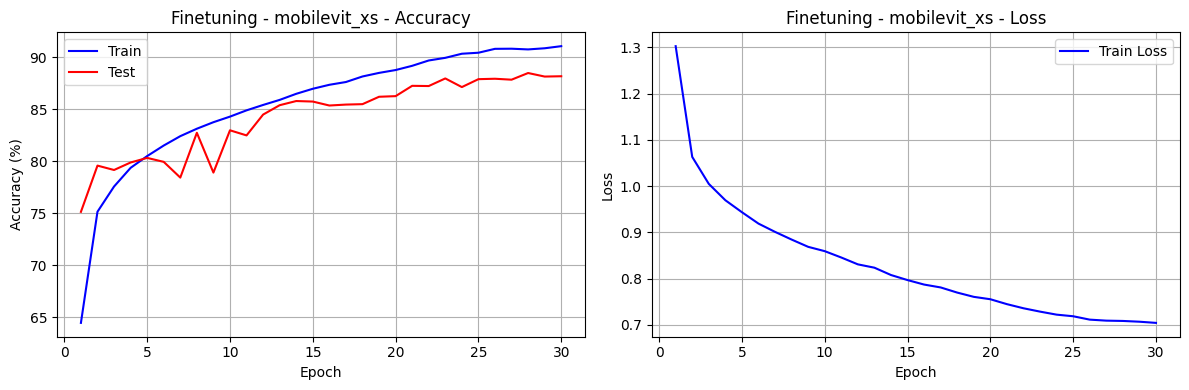

💾 Finetuned model saved: mobilevit_xs_finetuned_cifar10.pth


accuracy,▁
best_accuracy,▁
final_lr,▁
flops,▁
freeze_epochs,▁
inference_time_ms,▁
model_size_mb,▁
parameters,▁
throughput_fps,▁
accuracy,88.16
best_accuracy,88.47



🎉 Finetuning complete!
   Best accuracy: 88.47%
   Final accuracy: 88.16%
   Model: mobilevit_xs (pretrained=True)


(ByobNet(
   (stem): ConvNormAct(
     (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn): BatchNormAct2d(
       16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
       (drop): Identity()
       (act): SiLU(inplace=True)
     )
   )
   (stages): Sequential(
     (0): Sequential(
       (0): BottleneckBlock(
         (conv1_1x1): ConvNormAct(
           (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn): BatchNormAct2d(
             64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
             (drop): Identity()
             (act): SiLU(inplace=True)
           )
         )
         (conv2_kxk): ConvNormAct(
           (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
           (bn): BatchNormAct2d(
             64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
             (drop): Identity()
             (ac

In [62]:
run_full_training()

In [53]:
# Cell 9: Model Comparison
# ========================================
def compare_models():
    """Compare different model variants"""
    print("🔬 Comparing model variants...")
    
    variants = [
        'mobilenetv3_small_100',
        'mobilenetv3_large_100', 
        'efficientnet_b0',
        'resnet18'
    ]
    
    comparison = []
    
    for variant in variants:
        try:
            model = timm.create_model(variant, num_classes=10)
            params = sum(p.numel() for p in model.parameters())
            flops = count_flops_simple(model)
            inference_time = measure_inference_time(model)
            
            comparison.append({
                'Model': variant,
                'Params (M)': params / 1e6,
                'FLOPs (M)': flops / 1e6,
                'Inference (ms)': inference_time,
                'FPS': 1000 / inference_time
            })
            
        except Exception as e:
            print(f"⚠️ {variant}: {e}")
    
    # Print comparison
    print(f"\n{'Model':<20} {'Params(M)':<10} {'FLOPs(M)':<10} {'Time(ms)':<10} {'FPS':<10}")
    print("-" * 60)
    for item in comparison:
        print(f"{item['Model']:<20} {item['Params (M)']:<10.2f} {item['FLOPs (M)']:<10.1f} "
              f"{item['Inference (ms)']:<10.2f} {item['FPS']:<10.1f}")
    
    return comparison

comparison_results = compare_models()

🔬 Comparing model variants...

Model                Params(M)  FLOPs(M)   Time(ms)   FPS       
------------------------------------------------------------
mobilenetv3_small_100 1.53       3.1        2.45       407.5     
mobilenetv3_large_100 4.21       8.4        3.02       330.7     
efficientnet_b0      4.02       8.0        3.60       277.8     
resnet18             11.18      22.4       0.85       1173.3    
